Descompresion de datos

In [ ]:
import missingno as msno
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from unidecode import unidecode
from pandas.api.types import CategoricalDtype
import geopandas

In [ ]:
def iqr(x):
    """Función para calcular el Rango Intercuartílico."""
    return x.quantile(0.75) - x.quantile(0.25)

def mode(x):
    """Función para obtener la moda (el primer valor si hay múltiples)."""
    return x.mode().iloc[0] if not x.mode().empty else np.nan

def limpiar_texto(texto):
    if not isinstance(texto, str):
        return texto
    limpio = unidecode(texto)
    limpio = re.sub(r'[\s-]+', '_', limpio)
    limpio = re.sub(r'[^\w]', '', limpio)
    return limpio.lower()


In [ ]:
df_bases = pd.read_fwf(
    'datos/estaciones_smn.txt', 
    skiprows=2, 
    header=None, 
    encoding='latin-1'
)

nombres_columnas = [
    'nombre_original', 'provincia', 'lat_gr', 'lat_min',
    'lon_gr', 'lon_min', 'altura', 'nro', 'oaci'
]

df_bases.columns = nombres_columnas

df_bases['nombre_original'] = df_bases['nombre_original'].str.strip()
df_bases['provincia'] = df_bases['provincia'].str.strip()

df_bases['latitud'] = df_bases['lat_gr'] + np.sign(df_bases['lat_gr']) * (df_bases['lat_min'] / 60)
df_bases['longitud'] = df_bases['lon_gr'] + np.sign(df_bases['lon_gr']) * (df_bases['lon_min'] / 60)

df_bases = df_bases.drop(columns=['lat_gr', 'lat_min', 'lon_gr', 'lon_min'])

df_bases.head()


In [ ]:
nombres_originales_df_bases=df_bases['nombre_original'].unique()

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

nombre_excel = "Estadísticas normales Datos abiertos 1991-2020.xlsx"
ruta_completa = os.path.join('datos', nombre_excel)

if not os.path.exists(ruta_completa):
    print(f"Error: El archivo '{ruta_completa}' no se encontró. Asegúrate de que el archivo ZIP se descomprimió correctamente y el archivo .xlsx está en la carpeta 'datos'.")
else:
    try:
        # Cargar sin especificar header para ver el raw data y encontrar la fila correcta
        df = pd.read_excel(ruta_completa, header=None)
        header_row_index = -1
        for i in range(min(10, len(df))):
            row_as_str = df.iloc[i].astype(str).str.lower()
            if ('estación' in row_as_str.values and 'valor medio de' in row_as_str.values):
                header_row_index = i
                break

        if header_row_index != -1:
            print(f"\n¡Encabezado detectado en la fila (0-indexada): {header_row_index}!")
    except Exception as e:
        print(f"Ocurrió un error al intentar la carga inicial para depuración: {e}")
        

df = pd.read_excel(ruta_completa, header=header_row_index)
df_largo = df.melt(
    id_vars=['Estación', 'Valor Medio de'],
    var_name='Mes',
    value_name='Valor'
)

# --- Limpieza de Nombres y Caracteres Especiales ---

# Renombrar las variables a un formato limpio (sin espacios ni símbolos)
mapa_nombres = {
    'Temperatura (°C)': 'temperatura_c',
    'Temperatura máxima (°C)': 'temperatura_maxima_c',
    'Temperatura mínima (°C)': 'temperatura_minima_c',
    'Humedad relativa (%)': 'humedad_relativa_porcentaje',
    'Velocidad del Viento (km/h) (2011-2020)': 'velocidad_viento_kmh',
    'Nubosidad total (octavos)': 'nubosidad_octavos',
    'Precipitación (mm)': 'precipitacion_mm',
    'Frecuencia de días con Precipitación superior a 1.0 mm': 'frecuencia_dias_precipitacion_gt_1mm'
}
estaciones_df_final=df_largo['Estación'].unique()
df_largo['Variable'] = df_largo['Valor Medio de'].replace(mapa_nombres)
df_largo = df_largo.drop(columns=['Valor Medio de'])
df_largo['Estación'] = df_largo['Estación'].apply(limpiar_texto)
df_largo['Mes'] = df_largo['Mes'].apply(limpiar_texto)
df_bases['Estación'] = df_bases['nombre_original'].apply(limpiar_texto)
df_bases = df_bases.drop(columns=['nombre_original'])
# Procesamiento de valores
df_largo['Valor'] = pd.to_numeric(df_largo['Valor'], errors='coerce')


# --- Creación del DataFrame Final ---
columnas_ordenadas = ['Estación', 'Variable', 'Mes', 'Valor']
df_final = df_largo[columnas_ordenadas].copy()


# Definir el orden correcto de los meses
meses_ordenados = [
    'ene', 'feb', 'mar', 'abr', 'may', 'jun',
    'jul', 'ago', 'sep', 'oct', 'nov', 'dic'
]

# Crear el tipo de dato Categórico con el orden definido
tipo_mes_categorico = CategoricalDtype(categories=meses_ordenados, ordered=True)

# Aplicar el nuevo tipo a la columna 'Mes'
df_final['Mes'] = df_final['Mes'].astype(tipo_mes_categorico)

correcciones_estaciones = {
    'coronel_pringles_aero': 'coronel_pringles_aero',
    'el_trebol': 'el_trebol',
    'presidencia_roque_saenz_pena_aero': 'presidencia_roque_saenz_pena_a', 
    'san_miguel': 'san_miguel',
}

df_final['Estación'] = df_final['Estación'].map(correcciones_estaciones).fillna(df_final['Estación'])
df_enriquecido = pd.merge(
    left=df_final,
    right=df_bases, 
    on='Estación',
    how='left'
)

mapa_regiones = {
    'jujuy': 'NOA',
    'salta': 'NOA',
    'formosa': 'NEA',
    'misiones': 'NEA',
    'tucuman': 'NOA',
    'santiago del es': 'NOA',
    'chaco': 'NEA',
    'corrientes': 'NEA',
    'catamarca': 'NOA',
    'la rioja': 'NOA',
    'cordoba': 'Pampeana',
    'santa fe': 'Pampeana',
    'san juan': 'Cuyo',
    'entre rios': 'NEA',
    'mendoza': 'Cuyo',
    'san luis': 'Cuyo',
    'la pampa': 'Pampeana',
    'buenos aires': 'Pampeana',
    'capital federal': 'Pampeana',
    'neuquen': 'Patagonia',
    'rio negro': 'Patagonia',
    'chubut': 'Patagonia',
    'santa cruz': 'Patagonia',
    'tierra del fueg': 'Patagonia', 
    'antartida': 'Antártida'
}
# Limpiamos la columna 'provincia' y creamos la columna 'region'
df_enriquecido['region'] = df_enriquecido['provincia'].str.lower().map(mapa_regiones)
df_enriquecido.to_csv('datos/dataframe_enriquecido.csv', index=False)

In [ ]:
estaciones_final_limpias = set(df_final['Estación'].unique())
estaciones_bases_limpias = set(df_bases['Estación'].unique())

no_coinciden_en_final = sorted(list(estaciones_final_limpias - estaciones_bases_limpias))
no_coinciden_en_bases = sorted(list(estaciones_bases_limpias - estaciones_final_limpias))

print("\n---")
print("Estaciones en df_final (LIMPIAS) que NO se encuentran en df_bases (LIMPIAS):")
if no_coinciden_en_final:
    for nombre in no_coinciden_en_final:
        print(f"- {nombre}")
else:
    print("¡Todos los nombres limpios de df_final['Estación'] se encuentran en df_bases['Estación']!")

print("\n---")
print("Estaciones en df_bases (LIMPIAS) que NO se encuentran en df_final (LIMPIAS):")
if no_coinciden_en_bases:
    for nombre in no_coinciden_en_bases:
        print(f"- {nombre}")
else:
    print("¡Todos los nombres limpios de df_bases['Estación'] se encuentran en df_final['Estación']!")
print("---")

| Variable      | Descripción                                                                 |
| :------------ | :-------------------------------------------------------------------------- |
| `Estación`    | Nombre de la estación meteorológica.                                        |
| `Variable`    | Tipo de variable climática medida (ej., temperatura, humedad).             |
| `Mes`         | Mes en que se registró el valor de la variable.                             |
| `Valor`       | Valor numérico de la variable medida.                                       |
| `provincia`   | Provincia donde se encuentra la estación meteorológica.                     |
| `altura`      | Altitud de la estación meteorológica en metros sobre el nivel del mar.      |
| `nrooac`      | Número o código de identificación de la estación según la OACI (Organización de Aviación Civil Internacional) |
| `latitud`     | Latitud geográfica de la estación en grados decimales.                     |
| `longitud`    | Longitud geográfica de la estación en grados decimales.                    |
| `region`      | Región geográfica a la que pertenece la estación.                           |

In [ ]:
df_enriquecido.head()

In [ ]:
df_enriquecido.info()

In [ ]:
df_enriquecido.isnull()

In [ ]:
df_enriquecido.isna()

In [ ]:
df_enriquecido.isnull().sum() 

In [ ]:
df_enriquecido.isna().mean().round(4)*100

In [ ]:
df_enriquecido.dtypes

In [ ]:
df_enriquecido['Mes'].unique()

In [ ]:
df_enriquecido['Variable'].unique()

In [ ]:
df_enriquecido['Estación'].unique()

In [ ]:
df_enriquecido['provincia'].unique()

In [ ]:
df_pivoted = df_enriquecido.pivot_table(
    index=['Estación', 'Variable'],
    columns='Mes',
    values='Valor'
)
msno.bar(df_pivoted, fontsize=12, figsize=(15, 8), color='steelblue')
plt.title('Cantidad de Datos no Nulos por Mes (Ordenado)', fontsize=20)
plt.xlabel('Meses', fontsize=15)
plt.ylabel('Observaciones no nulas', fontsize=15)
plt.show()


In [ ]:
msno.matrix(df_pivoted, figsize=(20,8))

In [ ]:
msno.heatmap(df_pivoted, fontsize=15, figsize=(15,8))
plt.title("Correlación de datos nulos", fontsize=15)
plt.show()

In [ ]:
msno.dendrogram(df_pivoted, figsize=(15,8))
plt.title('Dendrograma de faltantes', fontsize=20)
plt.show()

In [ ]:
def nulos_por_grupo(df, grupo_cols, target_col):
    agrupar_nulos = (
        df.groupby(grupo_cols, observed=True)[target_col]
        .apply(lambda x: x.isnull().mean() * 100)
        .reset_index(name=f'porcentaje_nulos_{target_col}')
    )
    return agrupar_nulos

# Ejemplos de análisis para 'Valor' (re-generamos para tener los DataFrames)
nulos_valor_por_estacion = nulos_por_grupo(df_enriquecido, 'Estación', 'Valor')
nulos_valor_por_variable = nulos_por_grupo(df_enriquecido, 'Variable', 'Valor')
nulos_valor_por_provincia = nulos_por_grupo(df_enriquecido, 'provincia', 'Valor')
nulos_valor_por_estacion_variable = nulos_por_grupo(df_enriquecido, ['Estación', 'Variable'], 'Valor')

# --- Cómo ordenar de mayor a menor ---

print("--- Nulos en 'Valor' por Estación (Ordenado de mayor a menor) ---")
nulos_age_por_estacion_ordenado = nulos_valor_por_estacion.sort_values(
    by='porcentaje_nulos_Valor',
    ascending=False
)
print(nulos_age_por_estacion_ordenado, "\n")


print("--- Nulos en 'Valor' por Variable (Ordenado de mayor a menor) ---")
nulos_valor_por_variable_ordenado = nulos_valor_por_variable.sort_values(
    by='porcentaje_nulos_Valor',
    ascending=False
)
print(nulos_valor_por_variable_ordenado, "\n")


print("--- Nulos en 'Valor' por provincia (Ordenado de mayor a menor) ---")
nulos_valor_por_provincia_ordenado = nulos_valor_por_provincia.sort_values(
    by='porcentaje_nulos_Valor',
    ascending=False
)
print(nulos_valor_por_provincia_ordenado, "\n")


print("--- Nulos en 'Valor' por Estación y Variable (Ordenado de mayor a menor) ---")
nulos_valor_por_estacion_variable_ordenado = nulos_valor_por_estacion_variable.sort_values(
    by='porcentaje_nulos_Valor',
    ascending=False
)
print(nulos_valor_por_estacion_variable_ordenado, "\n")


# Tipos de datos faltantes

### 1. MAR (Missing at Random)
* **Qué es:** la falta del dato se explica por otra variable que sí podemos observar.
* **Ejemplo:** la **velocidad del viento** falta por completo en la estación **Orán Aero**, probablemente porque esa estación no tenía el equipamiento necesario. La ausencia depende de la variable `Estación`.

### 2. MNAR (Missing Not at Random)
* **Qué es:** la falta del dato es causada por el propio valor que no se pudo medir.
* **Ejemplo:** un termómetro que se congela y deja de reportar datos solo cuando la temperatura es extremadamente baja. La ausencia depende del valor extremo que no se registró.

### 3. MCAR (Missing Completely at Random)
* **Qué es:** la ausencia es puramente accidental y no tiene relación con ninguna variable.
* **Ejemplo:** un error humano al anotar un único dato al azar. Es poco probable que explique los patrones sistemáticos de tus datos.

---

# Interpretación detallada de los nulos por grupos

El orden de los resultados por porcentaje de nulos ofrece una visión clara y rápida de dónde se concentran los valores faltantes en la columna `Valor`. A continuación, se analiza cada agrupación.

---

## Nulos en 'Valor' por estación


### Análisis
Se observa una clara concentración de nulos en las **estaciones antárticas** (`Base Belgrano II`, `Base Marambio`, `Base Esperanza`, `Base San Martín`) y `Obera`, con porcentajes de nulos extremadamente altos (entre 46.8% y 50%). Esto sugiere problemas crónicos de recolección o transmisión de datos debido a su ubicación remota o condiciones extremas. En contraste, muchas estaciones presentan un 0% de nulos.

### Implicación
Los datos **no son MCAR** (Missing Completely At Random). La ausencia de datos en `Valor` está fuertemente condicionada por la `Estación`. Es más probable que sean **MNAR** (Missing Not At Random), porque las fallas en los equipos se relacionan directamente con las condiciones extremas que se intentan medir.

---

## Nulos en 'Valor' por variable


### Análisis
Esta tabla es muy reveladora. La variable **`velocidad_viento_kmh` se destaca de forma drástica con casi un 40% de nulos**. Las variables de precipitación también tienen un porcentaje notablemente alto (casi 10%), mientras que las de temperatura y nubosidad presentan muy pocos nulos.

### Implicación
Nuevamente, los datos **no son MCAR**. La probabilidad de un valor nulo en `Valor` depende fuertemente de la `Variable` que se mide. Este es un fuerte indicio de **MAR**, donde la ausencia se explica por el tipo de medición. Por ejemplo, los anemómetros (medidores de viento) podrían ser más propensos a fallar que otros sensores.

---

## Nulos en 'Valor' por provincia


### Análisis
La provincia de **Antártida** es, con diferencia, la que presenta la mayor proporción de nulos (casi 45%), lo cual es consistente con el análisis por estación. Le siguen **Chaco** y **Misiones**. Por otro lado, un gran número de provincias no tienen ningún valor nulo.

### Implicación
Esto confirma que los datos **no son MCAR**. La `provincia` de origen es un factor muy importante que explica la presencia de nulos.

---

## Nulos en 'Valor' por estación y variable

### Análisis
Esta tabla ofrece la prueba más contundente. Vemos que combinaciones específicas de `Estación` y `Variable` tienen un **100% de nulos**.

### Implicación
Definitivamente, los datos **no son MCAR**. La ausencia es **sistemática** y depende de la combinación de *dónde* (`Estación`) y *qué* (`Variable`) se mide. Esto es un caso claro de **MAR** e incluso podría tener componentes de **MNAR**, si la falta de registro se debe a que la medición es imposible de obtener en ciertas condiciones.

---

## Conclusión general

Con base en todos los análisis, podemos afirmar con alta confianza que los datos faltantes en la columna `Valor` **no son MCAR**. La distribución de los nulos es altamente dependiente de la `Estación` y de la `Variable`.

Esto indica que el mecanismo de pérdida es **MAR (Missing At Random)**, ya que la probabilidad de que un valor falte se relaciona de forma sistemática con otra información que sí tenemos en el conjunto de datos.


In [ ]:
estadisticas_generales = df_enriquecido.groupby('Variable').agg(
    media=('Valor', 'mean'),
    mediana=('Valor', 'median'),
    moda=('Valor', mode),
    iqr=('Valor', iqr),
    asimetria_pearson=('Valor', pd.Series.skew),
    curtosis_fisher=('Valor', pd.Series.kurt),
    minimo=('Valor', 'min'),
    maximo=('Valor', 'max') 
)

g = sns.displot(
    data=df_enriquecido,
    x='Valor',
    col='Variable',
    col_wrap=4,
    kind='hist',
    kde=True,
    facet_kws={'sharey': False, 'sharex': False}
)

for ax in g.axes.flat:
    titulo = ax.get_title()
    nombre_variable = titulo.split(' = ')[1]
    stats_variable = estadisticas_generales.loc[nombre_variable]

    if not stats_variable.empty:
        min_val = stats_variable['minimo']
        max_val = stats_variable['maximo']
        padding = (max_val - min_val) * 0.05
        ax.set_xlim(min_val - padding, max_val + padding)
        
        media = stats_variable['media']
        mediana = stats_variable['mediana']
        moda = stats_variable['moda']
        r_iqr = stats_variable['iqr']
        asim = stats_variable['asimetria_pearson']
        curt = stats_variable['curtosis_fisher']
        
        ax.axvline(media, color='red', linestyle='--', linewidth=2, label=f'Media: {media:.2f}')
        ax.axvline(mediana, color='green', linestyle='-', linewidth=2, label=f'Mediana: {mediana:.2f}')
        
        texto_stats = (
            f"Moda: {moda:.2f}\n"
            f"IQR: {r_iqr:.2f}\n"
            f"Asimetría: {asim:.2f}\n"
            f"Curtosis: {curt:.2f}"
        )
        
        ax.text(0.95, 0.95, texto_stats,
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.7))
        
        ax.legend()

g.fig.suptitle('Distribución de Variables con Estadísticas y Ejes Ajustados', y=1.03, fontsize=20)
g.tight_layout()
plt.show()

In [ ]:
provincia_seleccionada = 'MENDOZA'  # Cambiar esto por la provincia que quieras analizar
df_provincia = df_enriquecido[df_enriquecido['provincia'] == provincia_seleccionada]

estadisticas_provincia = df_provincia.groupby('Variable').agg(
    media=('Valor', 'mean'),
    mediana=('Valor', 'median'),
    moda=('Valor', mode),
    iqr=('Valor', iqr),
    asimetria_pearson=('Valor', pd.Series.skew),
    curtosis_fisher=('Valor', pd.Series.kurt),
    minimo=('Valor', 'min'),
    maximo=('Valor', 'max')
)

print(f"--- Estadísticas para la provincia de: {provincia_seleccionada} ---")
print(estadisticas_provincia)


g = sns.displot(
    data=df_provincia,
    x='Valor',
    col='Variable',
    col_wrap=4,
    kind='hist',
    kde=True,
    facet_kws={'sharey': False, 'sharex': False}
)

for ax in g.axes.flat:
    titulo = ax.get_title()
    nombre_variable = titulo.split(' = ')[1]

    stats_variable = estadisticas_provincia.loc[nombre_variable]

    if not stats_variable.empty:
        min_val = stats_variable['minimo']
        max_val = stats_variable['maximo']
        padding = (max_val - min_val) * 0.30
        if padding == 0: padding = 1 
        ax.set_xlim(min_val - padding, max_val + padding)
        
        media = stats_variable['media']
        mediana = stats_variable['mediana']
        moda = stats_variable['moda']
        r_iqr = stats_variable['iqr']
        asim = stats_variable['asimetria_pearson']
        curt = stats_variable['curtosis_fisher']
        
        ax.axvline(media, color='red', linestyle='--', linewidth=2, label=f'Media: {media:.2f}')
        ax.axvline(mediana, color='green', linestyle='-', linewidth=2, label=f'Mediana: {mediana:.2f}')
        
        texto_stats = (
            f"Moda: {moda:.2f}\n"
            f"IQR: {r_iqr:.2f}\n"
            f"Asimetría: {asim:.2f}\n"
            f"Curtosis: {curt:.2f}"
        )
        
        ax.text(0.95, 0.95, texto_stats,
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.7))
        
        ax.legend()

g.fig.suptitle(f'Distribución de Variables en {provincia_seleccionada}', y=1.03, fontsize=20)
g.tight_layout()
plt.show()


In [ ]:
# 1. Filtrar para una sola variable de interés
variable_a_analizar = 'temperatura_c'
df_filtrado_region = df_enriquecido[df_enriquecido['Variable'] == variable_a_analizar].copy()

# 2. Calcular los rangos (mínimo y máximo) para cada región
rangos_por_region = df_filtrado_region.groupby('region')['Valor'].agg(['min', 'max'])

# 3. Crear el gráfico de distribución con ejes independientes
g = sns.displot(
    data=df_filtrado_region,
    x='Valor',
    col='region',
    col_wrap=3,
    kind='hist',
    kde=True,
    facet_kws={'sharey': False, 'sharex': False} # Ejes X independientes
)

# 4. Iterar sobre cada eje para ajustar la escala dinámicamente
for ax in g.axes.flat:
    titulo = ax.get_title()
    nombre_region = titulo.split(' = ')[1]

    if nombre_region in rangos_por_region.index:
        min_val = rangos_por_region.loc[nombre_region, 'min']
        max_val = rangos_por_region.loc[nombre_region, 'max']
        
        padding = (max_val - min_val) * 0.3
        
        ax.set_xlim(min_val - padding, max_val + padding)

# 5. Ajustar títulos y mostrar
g.fig.suptitle(f'Distribución de "{variable_a_analizar}" por Región', y=1.03, fontsize=20)
g.set_axis_labels("Temperatura (°C)", "Frecuencia")
g.fig.tight_layout()
plt.show()

In [ ]:
# 1. Filtrar para una sola variable de interés
variable_a_analizar = 'nubosidad_octavos'
df_filtrado_region = df_enriquecido[df_enriquecido['Variable'] == variable_a_analizar].copy()

# 2. Calcular los rangos (mínimo y máximo) para cada región
rangos_por_region = df_filtrado_region.groupby('region')['Valor'].agg(['min', 'max'])

# 3. Crear el gráfico de distribución con ejes independientes
g = sns.displot(
    data=df_filtrado_region,
    x='Valor',
    col='region',
    col_wrap=3,
    kind='hist',
    kde=True,
    facet_kws={'sharey': False, 'sharex': False} # Ejes X independientes
)

# 4. Iterar sobre cada eje para ajustar la escala dinámicamente
for ax in g.axes.flat:
    titulo = ax.get_title()
    nombre_region = titulo.split(' = ')[1]

    if nombre_region in rangos_por_region.index:
        min_val = rangos_por_region.loc[nombre_region, 'min']
        max_val = rangos_por_region.loc[nombre_region, 'max']
        
        padding = (max_val - min_val) * 0.3
        
        ax.set_xlim(min_val - padding, max_val + padding)

# 5. Ajustar títulos y mostrar
g.fig.suptitle(f'Distribución de "{variable_a_analizar}" por Región', y=1.03, fontsize=20)
g.set_axis_labels("Nubosidad octavos ", "Frecuencia")
g.fig.tight_layout()
plt.show()

In [ ]:
sns.set_theme(style="whitegrid")

g = sns.relplot(
    data=df_enriquecido,
    x='Mes',
    y='Valor',
    col='Variable',
    kind='line',
    col_wrap=4,
    height=3,
    aspect=1.5,
    facet_kws={'sharey': False, 'sharex': True}
)

g.fig.suptitle('Evolución Anual de las Variables Climáticas', y=1.03, fontsize=20)
g.set_titles("Variable: {col_name}")
g.set_axis_labels("Mes", "Valor Promedio")
plt.tight_layout()
plt.show()

## Descripción General de las Distribuciones de Variables Climáticas

### 1. Temperatura ($temperatura\_c$)

* **Evolución Anual (General):** Sigue un patrón estacional claro, con valores promedio bajos en invierno (julio) y altos en verano (enero-febrero). La banda sombreada indica una variabilidad considerable a lo largo del año.
* **Distribución General:** La distribución general de la temperatura tiende a ser bimodal o presenta una ligera asimetría, con una cola más larga hacia valores más bajos. La media se sitúa alrededor de 14.83 °C y la mediana en 15.70 °C, sugiriendo una ligera asimetría negativa. El rango intercuartílico (IQR) es de 10.98, indicando una dispersión moderada. La curtosis de 1.77 sugiere colas más ligeras que una distribución normal.
* **Distribución en Mendoza:** En Mendoza, la distribución de la temperatura ($temperatura\_c$) se centra alrededor de una media de 15.59 °C y una mediana de 15.95 °C. Presenta un IQR de 10.72 y una curtosis de -1.27, lo que indica una distribución más aplanada (platicúrtica) y posiblemente bimodal o con dos picos, uno alrededor de 10-15°C y otro cerca de 20-25°C. La asimetría es de -0.06, lo que sugiere una distribución casi simétrica o ligeramente sesgada a la izquierda.
* **Distribución por Región:** La distribución de temperatura varía significativamente por región.
    * **NOA, NEA, Pampeana y Cuyo:** Muestran distribuciones que parecen bimodales o con un rango amplio de temperaturas, reflejando las variaciones estacionales. Las temperaturas promedio son más cálidas en estas regiones.
    * **Patagonia:** Presenta un rango de temperaturas más bajas y una distribución más concentrada en valores fríos, aunque con cierta variabilidad.
    * **Antártida:** Exhibe las temperaturas más bajas y una distribución notablemente sesgada hacia valores negativos, con un rango de temperatura mucho más frío en comparación con las demás regiones.

### 2. Temperatura Máxima ($temperatura\_maxima\_c$)

* **Evolución Anual (General):** Al igual que la temperatura promedio, la temperatura máxima muestra una clara estacionalidad, alcanzando sus picos en los meses de verano y sus mínimos en invierno.
* **Distribución General:** La distribución general de la temperatura máxima tiene una media de 21.22 °C y una mediana de 22.40 °C. El IQR es de 13.68, lo que indica una dispersión considerable. La asimetría de -0.08 sugiere una distribución casi simétrica. La curtosis de -0.94 indica que la distribución es más aplanada (platicúrtica) que una normal.
* **Distribución en Mendoza:** Para Mendoza, la temperatura máxima ($temperatura\_maxima\_c$) tiene una media de 23.19 °C y una mediana de 23.45 °C. El IQR es de 13.29, y la asimetría de -0.28 indica un ligero sesgo hacia valores más bajos. La curtosis de -1.20 sugiere una distribución más aplanada que la normal.

### 3. Temperatura Mínima ($temperatura\_minima\_c$)

* **Evolución Anual (General):** La temperatura mínima también sigue un patrón estacional, con los valores más bajos en invierno y los más altos en verano.
* **Distribución General:** La distribución general de la temperatura mínima muestra una media de 9.30 °C y una mediana de 9.90 °C. El IQR es de 10.60, indicando una dispersión similar a la temperatura máxima. La asimetría es de -0.08, sugiriendo una distribución casi simétrica. La curtosis de -1.69 indica que es más aplanada que una distribución normal.
* **Distribución en Mendoza:** La temperatura mínima ($temperatura\_minima\_c$) en Mendoza presenta una media de 8.94 °C y una mediana de 8.75 °C. Con un IQR de 10.22 y una asimetría de -0.01, la distribución es casi simétrica. La curtosis de -1.15 la hace más aplanada que una distribución normal.

### 4. Humedad Relativa ($humedad\_relativa\_porcentaje$)

* **Evolución Anual (General):** La humedad relativa muestra una tendencia estacional inversa a la temperatura, con valores más altos en los meses más fríos y más bajos en los meses más cálidos.
* **Distribución General:** La distribución general de la humedad relativa es multimodal o tiene una forma irregular. La media se encuentra en 68.01 % y la mediana en 70.10 %. El IQR de 13.08 indica una dispersión moderada. La asimetría de -0.22 sugiere un ligero sesgo hacia valores más altos de humedad. La curtosis de 0.12 indica una forma similar a una normal o ligeramente más puntiaguda.
* **Distribución en Mendoza:** En Mendoza, la humedad relativa ($humedad\_relativa\_porcentaje$) tiene una media de 56.09 % y una mediana de 54.10 %. El IQR es de 10.98 y la asimetría de -1.01, lo que indica un sesgo significativo hacia valores más altos de humedad. La curtosis de -1.01 sugiere una distribución más aplanada.

### 5. Velocidad del Viento ($velocidad\_viento\_kmh$)

* **Evolución Anual (General):** La velocidad del viento presenta cierta estacionalidad, con valores ligeramente más altos en primavera-verano y más bajos en invierno.
* **Distribución General:** La distribución general de la velocidad del viento parece tener una cola larga hacia valores más altos, indicando la ocurrencia de vientos fuertes ocasionales. La media es de 10.40 km/h y la mediana de 11.85 km/h. El IQR es de 6.94 y la asimetría de 0.96, confirmando un sesgo positivo (hacia la derecha). La curtosis de 0.97 indica colas más pesadas que una normal.
* **Distribución en Mendoza:** En Mendoza, la velocidad del viento ($velocidad\_viento\_kmh$) tiene una media de 10.50 km/h y una mediana de 10.40 km/h. El IQR es de 3.80, lo que sugiere una menor dispersión en comparación con la distribución general. La asimetría de 1.02 y una curtosis de 0.87 confirman un sesgo positivo y colas más pesadas.

### 6. Nubosidad ($nubosidad\_octavos$)

* **Evolución Anual (General):** La nubosidad muestra fluctuaciones a lo largo del año, con valores ligeramente más altos en los meses de invierno y primavera.
* **Distribución General:** La distribución general de la nubosidad es marcadamente asimétrica, concentrándose en valores bajos (poca nubosidad) y con una cola que se extiende hacia valores más altos (mayor nubosidad). La media es de 3.70 octavos y la mediana de 3.84 octavos. El IQR de 1.90 y la asimetría de 0.70 reflejan este sesgo positivo. La curtosis de 3.38 indica una distribución con un pico más agudo y colas más pesadas que una normal.
* **Distribución en Mendoza:** La nubosidad ($nubosidad\_octavos$) en Mendoza tiene una media de 2.99 octavos y una mediana de 3.00 octavos, lo que sugiere cielos generalmente menos nublados que en el promedio general. El IQR es de 0.50, lo que indica una distribución más concentrada. La asimetría de 0.14 y una curtosis de -1.04 sugieren una distribución más simétrica y aplanada en comparación con la distribución general.

### 7. Precipitación ($precipitacion\_mm$)

* **Evolución Anual (General):** La precipitación es altamente estacional, con los mayores volúmenes concentrados en los meses de verano (especialmente de diciembre a marzo) y mínimos en invierno.
* **Distribución General:** La distribución general de la precipitación está fuertemente sesgada hacia cero, con una gran cantidad de días sin precipitación o con muy poca, y una larga cola hacia valores más altos que representan eventos de lluvia intensos. La media es de 24.40 mm y la mediana de 68.22 mm. El IQR de 83.90 y la asimetría de 1.50 confirman un fuerte sesgo positivo. La curtosis de 0.26 indica colas más pesadas que una normal.
* **Distribución en Mendoza:** La precipitación ($precipitacion\_mm$) en Mendoza tiene una media de 24.18 mm y una mediana de 23.85 mm. El IQR de 60.90 y la asimetría de 0.81 indican un sesgo positivo, aunque posiblemente menos pronunciado que en la distribución general, reflejando el clima más árido de la región. La curtosis de -0.21 sugiere una distribución ligeramente más aplanada.

### 8. Frecuencia de Días con Precipitación > 1mm ($frecuencia\_dias\_precipitacion\_gt\_1mm$)

* **Evolución Anual (General):** La frecuencia de días con precipitación sigue un patrón estacional similar a la precipitación total, siendo más alta en los meses de verano y más baja en invierno.
* **Distribución General:** La distribución general de la frecuencia de días con precipitación > 1mm también está sesgada hacia valores bajos, indicando que los días con precipitación significativa son menos frecuentes. La media es de 5.10 días y la mediana de 5.20 días. El IQR de 1.90 y la asimetría de 0.19 sugieren un ligero sesgo positivo. La curtosis de -0.10 indica una forma similar a una distribución normal.
* **Distribución en Mendoza:** La frecuencia de días con precipitación > 1mm ($frecuencia\_dias\_precipitacion\_gt\_1mm$) en Mendoza tiene una media de 2.93 días y una mediana de 2.80 días. El IQR es de 0.83, lo que sugiere una menor variabilidad. La asimetría de 0.77 y una curtosis de 0.33 indican un sesgo positivo y colas ligeramente más pesadas, lo que es consistente con una región con menor frecuencia de lluvias significativas.

In [ ]:

gdf_estaciones = geopandas.GeoDataFrame(
    df_bases, 
    geometry=geopandas.points_from_xy(df_bases.longitud, df_bases.latitud),
    crs="EPSG:4326"
)

#  2. Preparar los Datos a Visualizar 
df_temperatura_media = df_enriquecido[df_enriquecido['Variable'] == 'temperatura_c'].groupby('Estación')['Valor'].mean().reset_index()
df_temperatura_media.rename(columns={'Valor': 'temp_media_anual'}, inplace=True)
#  3. Unir Datos  
gdf_final_para_mapa = pd.merge(
    gdf_estaciones,
    df_temperatura_media,
    on='Estación',
    how='inner'
)

#  4. Dibujar el Mapa 
ruta_al_mapa = "datos/pais/paisPolygon.shp"  # <-- CAMBIÁ ESTA RUTA
argentina_mapa = geopandas.read_file(ruta_al_mapa)


# Creamos la figura y el eje del gráfico
fig, ax = plt.subplots(1, 1, figsize=(10, 12))

# Dibujamos el mapa de provincias como base
argentina_mapa.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.5)

# Superponemos los puntos de las estaciones
gdf_final_para_mapa.plot(
    column='temp_media_anual', 
    ax=ax, 
    legend=True,
    cmap='coolwarm',
    markersize=50,
    legend_kwds={'label': "Temperatura Media Anual (°C)", 'orientation': "horizontal"}
)

# Configuramos el título y los ejes
ax.set_title('Temperatura Media Anual por Estación Meteorológica', fontsize=18)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_aspect('equal')
plt.show()

In [ ]:
# a) Calcular la temperatura media por provincia
df_temp_provincia = df_enriquecido[df_enriquecido['Variable'] == 'temperatura_c'].groupby('provincia')['Valor'].mean().reset_index()

# b) Renombrar la columna 'Valor' a su nombre final
df_temp_provincia.rename(columns={'Valor': 'temp_media_provincial'}, inplace=True)

# c) Limpiar los nombres de las provincias para la unión
df_temp_provincia['provincia_limpia'] = df_temp_provincia['provincia'].apply(limpiar_texto)

mapa_correcciones = {
    'tierra_del_fueg': 'tierra_del_fuego_antartida_e_islas_del_atlantico_sur',
    'santiago_del_es': 'santiago_del_estero',
    'capital_federal': 'ciudad_autonoma_de_buenos_aires'
}
df_temp_provincia['provincia_limpia'] = df_temp_provincia['provincia_limpia'].replace(mapa_correcciones)


#  2. PREPARAR DATOS DEL MAPA 

ruta_mapa_provincias = "datos/provincia/provinciaPolygon.shp"
mapa_provincias = geopandas.read_file(ruta_mapa_provincias)


mapa_provincias['provincia_limpia'] = mapa_provincias['nam'].apply(limpiar_texto)


#  3. UNIR LOS DATAFRAMES 

mapa_final = pd.merge(
    mapa_provincias,
    df_temp_provincia,
    on='provincia_limpia',
    how='left'
)


#  4. DIBUJAR EL MAPA 

print("Columnas disponibles en el mapa final:", mapa_final.columns)

fig, ax = plt.subplots(1, 1, figsize=(10, 12))

mapa_final.plot(
    column='temp_media_provincial',
    ax=ax,
    legend=True,
    cmap='coolwarm',
    linewidth=0.8,
    edgecolor='0.8',
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Sin datos",
    },
    legend_kwds={'label': "Temperatura Media Provincial (°C)", 'orientation': "horizontal"}
)

ax.set_title('Temperatura Media por Provincia', fontsize=18)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_aspect('equal')
plt.show()

In [ ]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt


#  1. PREPARAR DATOS DE NUBOSIDAD 
df_nubo_provincia = df_enriquecido[df_enriquecido['Variable'] == 'nubosidad_octavos'].groupby('provincia')['Valor'].mean().reset_index()
df_nubo_provincia.rename(columns={'Valor': 'nubo_media_provincial'}, inplace=True)
df_nubo_provincia['provincia_limpia'] = df_nubo_provincia['provincia'].apply(limpiar_texto)
mapa_correcciones = {
    'tierra_del_fueg': 'tierra_del_fuego_antartida_e_islas_del_atlantico_sur',
    'santiago_del_es': 'santiago_del_estero',
    'capital_federal': 'ciudad_autonoma_de_buenos_aires'
}
df_nubo_provincia['provincia_limpia'] = df_nubo_provincia['provincia_limpia'].replace(mapa_correcciones)

#  2. PREPARAR DATOS DEL MAPA 
ruta_mapa_provincias = "datos/provincia/provinciaPolygon.shp"
mapa_provincias = geopandas.read_file(ruta_mapa_provincias)
mapa_provincias['provincia_limpia'] = mapa_provincias['nam'].apply(limpiar_texto)

#  3. DICCIONARIO DE VARIABLES A PLOTEAR Y SUS PROPIEDADES 
variables_a_plotear = {
    'nubosidad_octavos': {
        'nombre_columna': 'nubo_media_provincial',
        'titulo': 'Nubosidad Media (octavos)',
        'cmap': 'Blues'
    },
      'temperatura_c': { 
        'nombre_columna': 'temp_media_provincial',
        'titulo': 'Temperatura Media (°C)',
        'cmap': 'OrRd'
    },
    'temperatura_maxima_c': {
        'nombre_columna': 'temp_max_media_provincial',
        'titulo': 'Temperatura Máxima Media (°C)',
        'cmap': 'YlOrRd'
    },
    'temperatura_minima_c': {
        'nombre_columna': 'temp_min_media_provincial',
        'titulo': 'Temperatura Mínima Media (°C)',
        'cmap': 'PuBu'
    },
    'precipitacion_mm': {
        'nombre_columna': 'precip_media_provincial',
        'titulo': 'Precipitación Media (mm)',
        'cmap': 'Greens'
    },
    'humedad_relativa_porcentaje': {
        'nombre_columna': 'humedad_media_provincial',
        'titulo': 'Humedad Relativa Media (%)',
        'cmap': 'GnBu'
    },
    'velocidad_viento_kmh': {
        'nombre_columna': 'viento_media_provincial',
        'titulo': 'Velocidad del Viento Media (km/h)',
        'cmap': 'cool'
    },
    'frecuencia_dias_precipitacion_gt_1mm': {
        'nombre_columna': 'frec_precip_media_provincial',
        'titulo': 'Frecuencia de Días con Precipitación > 1mm',
        'cmap': 'BuGn'
    }
}

#  4. CREAR EL SUBPLOT DE MAPAS 
n_variables = len(variables_a_plotear)
ncols = 2
nrows = (n_variables + ncols - 1) // ncols 

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 6, nrows * 7)) # Ajusta el tamaño de la figura
axes = axes.flatten() 

for i, (variable_original, props) in enumerate(variables_a_plotear.items()):
    ax = axes[i]

    # Prepara los datos para la variable actual
    df_variable_provincia = df_enriquecido[df_enriquecido['Variable'] == variable_original].groupby('provincia')['Valor'].mean().reset_index()
    df_variable_provincia.rename(columns={'Valor': props['nombre_columna']}, inplace=True)
    df_variable_provincia['provincia_limpia'] = df_variable_provincia['provincia'].apply(limpiar_texto)
    df_variable_provincia['provincia_limpia'] = df_variable_provincia['provincia_limpia'].replace(mapa_correcciones)

    # Une los dataframes
    mapa_final_variable = pd.merge(
        mapa_provincias,
        df_variable_provincia,
        on='provincia_limpia',
        how='left'
    )

    # Dibuja el mapa
    mapa_final_variable.plot(
        column=props['nombre_columna'],
        ax=ax,
        legend=True,
        cmap=props['cmap'],
        linewidth=0.8,
        edgecolor='0.8',
        missing_kwds={
            "color": "lightgrey",
            "edgecolor": "red",
            "hatch": "///",
            "label": "Sin datos",
        },
        legend_kwds={'label': props['titulo'], 'orientation': "horizontal", 'shrink': 0.6} # Shrink para reducir el tamaño de la leyenda
    )

    ax.set_title(props['titulo'], fontsize=12)
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    ax.set_aspect('equal')


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout() # Ajusta el layout para evitar solapamientos
plt.suptitle('Distribución de Variables Climáticas por Provincia', fontsize=20, y=1.02) # Título general
plt.show()

In [ ]:
#--- 1. Estadísticas Generales por Variable ---
print("--- 1. Estadísticas Generales por Variable ---")
estadisticas_generales = df_enriquecido.groupby('Variable').agg(
    conteo=('Valor', 'count'),
    media=('Valor', 'mean'),
    desvio_est=('Valor', 'std'),
    varianza=('Valor', 'var'),
    mediana=('Valor', 'median'),
    minimo=('Valor', 'min'),
    maximo=('Valor', 'max'),
    asimetria_pearson=('Valor', pd.Series.skew),
    curtosis_fisher=('Valor', pd.Series.kurt)
)
print(estadisticas_generales)

print("\n--- Moda por Variable ---")
moda_general = df_enriquecido.groupby('Variable')['Valor'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
print(moda_general)


# --- 2. Estadísticas por Región y Variable ---
print("\n" + "="*80)
print("--- 2. Estadísticas por Región y Variable ---")
estadisticas_por_region = df_enriquecido.groupby(['region', 'Variable']).agg(
    conteo=('Valor', 'count'),
    media=('Valor', 'mean'),
    desvio_est=('Valor', 'std'),
    varianza=('Valor', 'var'),
    mediana=('Valor', 'median'),
    minimo=('Valor', 'min'),
    maximo=('Valor', 'max'),
    asimetria_pearson=('Valor', pd.Series.skew),
    curtosis_fisher=('Valor', pd.Series.kurt)
)
print(estadisticas_por_region)

## Outlaiers

In [ ]:
sns.set_theme(style="whitegrid")

g = sns.FacetGrid(
    df_enriquecido, 
    col="Variable", 
    col_wrap=4, 
    sharey=False, 
    sharex=False, 
    height=4
)

g.map(sns.boxplot, "Valor")

g.set_axis_labels("Valor", "")
g.set_titles("{col_name}")
g.fig.suptitle("Análisis de Outliers por Variable", y=1.02, fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
Q1 = df_enriquecido.groupby('Variable')['Valor'].quantile(0.25)
Q3 = df_enriquecido.groupby('Variable')['Valor'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

limites = pd.DataFrame({'lim_inf': limite_inferior, 'lim_sup': limite_superior})
print("--- Límites para detección de outliers por Variable ---")
print(limites)

df_con_limites = pd.merge(df_enriquecido, limites, on='Variable', how='left')

outliers_generales = df_con_limites[
    (df_con_limites['Valor'] < df_con_limites['lim_inf']) | 
    (df_con_limites['Valor'] > df_con_limites['lim_sup'])
]

conteo_de_outliers = outliers_generales['Variable'].value_counts()

total_por_variable = df_enriquecido['Variable'].value_counts()

resumen_outliers = pd.DataFrame({
    'total_registros': total_por_variable,
    'cantidad_outliers': conteo_de_outliers
}).fillna(0)

resumen_outliers['porcentaje_outliers'] = (resumen_outliers['cantidad_outliers'] / resumen_outliers['total_registros']) * 100

print("\n--- Resumen Porcentual de Outliers por Variable ---")
print(resumen_outliers)

In [ ]:
sns.set_theme(style="whitegrid")
regiones= df_enriquecido['region'].astype(str).unique()
print(f"\n--- Regiones encontradas: {', '.join(regiones)} ---")
g = sns.FacetGrid(
    df_enriquecido, 
    col="Variable", 
    col_wrap=2,  
    sharex=False, 
    sharey=False, 
    height=6,   
    aspect=1.2
)


g.map(sns.boxplot, 'Valor', 'region', palette='viridis')
g.set_axis_labels("Valor", "Región")
g.set_titles("{col_name}")
g.fig.suptitle("Análisis de Outliers por Variable, Desglosado por Región", y=1.02, fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
# Calculamos los límites agrupando por región Y variable
Q1_region = df_enriquecido.groupby(['region', 'Variable'])['Valor'].quantile(0.25)
Q3_region = df_enriquecido.groupby(['region', 'Variable'])['Valor'].quantile(0.75)
IQR_region = Q3_region - Q1_region

# Calculamos los límites inferior y superior
lim_inf_region = Q1_region - 1.5 * IQR_region
lim_sup_region = Q3_region + 1.5 * IQR_region 

# Creamos un DataFrame con los límites
limites_region = pd.DataFrame({'lim_inf': lim_inf_region, 'lim_sup': lim_sup_region}).reset_index()
limites_region.head()
# Unimos los límites al DataFrame original
df_con_limites_region = pd.merge(df_enriquecido, limites_region, on=['region', 'Variable'], how='left')

# Filtramos los outliers usando los límites corregidos
outliers_region = df_con_limites_region[
    (df_con_limites_region['Valor'] < df_con_limites_region['lim_inf']) | 
    (df_con_limites_region['Valor'] > df_con_limites_region['lim_sup'])
]

conteo_outliers_region = outliers_region.groupby(['region', 'Variable']).size()
total_por_region = df_enriquecido.groupby(['region', 'Variable']).size()

resumen_outliers_region = pd.DataFrame({
    'total_registros': total_por_region,
    'cantidad_outliers': conteo_outliers_region
}).fillna(0)

resumen_outliers_region['porcentaje_outliers'] = \
    (resumen_outliers_region['cantidad_outliers'] / resumen_outliers_region['total_registros']) * 100

print("\n--- Resumen Porcentual de Outliers por Región ---")
print(resumen_outliers_region)

## 1. Límites de Detección

A continuación, se presentan los límites calculados para cada variable:

--- Límites para detección de outliers por Variable ---

| Variable                               | lim_inf | lim_sup |
|----------------------------------------|---------|---------|
| frecuencia_dias_precipitacion_gt_1mm  | -2.7500 | 12.8500 |
| humedad_relativa_porcentaje            | 38.7125 | 99.0125 |
| nubosidad_octavos                      | 1.9500  | 5.5500  |
| precipitacion_mm                       | -101.5000 | 231.3000 |
| temperatura_c                          | -6.0500 | 37.5500 |
| temperatura_maxima_c                   | 0.7125  | 44.2125 |
| temperatura_minima_c                   | -11.4000 | 31.0000 |
| velocidad_viento_kmh                   | -0.8500 | 25.9500 |

## 2. Análisis General de Outliers por Variable

**Observaciones:**

* **`nubosidad_octavos`** presenta el mayor porcentaje de outliers (5.87%), sugiriendo variaciones considerables en la cobertura nubosa.
* Las variables de temperatura (`temperatura_maxima_c`, `temperatura_c`, `temperatura_minima_c`) también muestran una cantidad notable de outliers, indicando registros de temperaturas inusualmente altas o bajas.
* **`precipitacion_mm`** tiene el menor porcentaje de outliers (0.26%), lo cual es esperable, ya que las precipitaciones extremadamente altas son eventos menos frecuentes.

## 3. Análisis de Outliers Desglosado por Región

### Diferencias Clave en los Outliers entre Regiones:

Las regiones presentan patrones distintivos en la aparición de outliers, lo que subraya la diversidad climática del país:

* **Antártida:** Destaca por la casi total ausencia de outliers, con la excepción de `temperatura_maxima_c`. Esto sugiere una menor variabilidad en sus condiciones climáticas en comparación con otras regiones.
* **Cuyo:** Muestra una alta concentración de outliers en variables relacionadas con la precipitación (`frecuencia_dias_precipitacion_gt_1mm` y `precipitacion_mm`), lo que podría indicar eventos de lluvias intensas o infrecuentes. No presenta outliers en temperatura ni viento. Esto se podria explicar por las tormentas de verano tipicas de esta region.
* **NEA y NOA:** Ambas regiones del norte exhiben outliers significativos en `velocidad_viento_kmh` y `precipitacion_mm`, además de `nubosidad_octavos` en el NEA.
* **Pampeana:** Se caracteriza por tener un bajo número de outliers en general, con solo `humedad_relativa_porcentaje` mostrando una proporción notable. Esto podría indicar una mayor estabilidad en sus patrones climáticos.
* **Patagonia:** Presenta un número considerable de outliers en `frecuencia_dias_precipitacion_gt_1mm` y `precipitacion_mm`, lo cual es coherente con su clima variable que puede incluir eventos de precipitación extremos. También se observan outliers en `nubosidad_octavos`.

***
## Planteamiento de un problema de machine learning supervisado: predicción del potencial solar relativo

### Descripción del problema: regresión para estimar irradiancia solar

El problema se define como una tarea de **regresión**. El objetivo es entrenar un modelo de machine learning que sea capaz de predecir el valor de un **índice relativo de irradiancia solar**, que hemos denominado `GHI_Proxy`.

El modelo aprenderá la relación entre un conjunto de variables predictoras (características meteorológicas y geográficas) y esta variable objetivo construida. En esencia, el modelo no predecirá una medida física directa en kWh/m², sino un valor numérico continuo que representa el potencial solar relativo. La utilidad de este enfoque es la capacidad de **clasificar y comparar** diferentes lugares y meses según su idoneidad para la generación de energía solar.

### Definición de la variable objetivo: `GHI_Proxy`

Dado que el conjunto de datos carece de una medida directa de irradiancia solar (como la Irradiancia Global Horizontal o GHI), se ha diseñado una **variable objetivo proxy** para superar esta limitación.

### Hipótesis para la construcción de la variable objetivo

La construcción de este proxy se basa en la siguiente hipótesis física: la **amplitud térmica diurna** (la diferencia entre la temperatura máxima y mínima) es un fuerte indicador de la cantidad de energía solar que incide sobre la superficie.

* Días Despejados: Una alta radiación solar provoca un gran calentamiento durante el día y un enfriamiento significativo durante la noche, resultando en una **gran amplitud térmica**.
* Días Nublados: La cobertura de nubes bloquea la radiación solar entrante (limitando la temperatura máxima) y retiene el calor saliente (elevando la temperatura mínima), lo que conduce a una **pequeña amplitud térmica**.

La nubosidad, por lo tanto, actúa como el principal factor que atenúa la energía solar recibida.

### Formulación de la variable

Basado en esta hipótesis, la variable objetivo `GHI_Proxy` se formula de la siguiente manera:

$$GHI\_Proxy = (temperatura\_maxima\_c - temperatura\_minima\_c) \times (1 - k \times nubosidad\_octavos)$$

Donde:
* `(temperatura_maxima_degc - temperatura_minima_degc)`: Representa la **amplitud térmica**, el motor principal del proxy.
* `nubosidad_total_octavos`: Es la variable que **atenúa directamente** el efecto de la amplitud térmica.
* `k`: Es una constante de escalamiento para ajustar el impacto de la nubosidad. Se propone un valor inicial de **k = 1/8**, asumiendo una relación lineal simple.

In [ ]:
# Se convierte el DataFrame largo a formato ancho
df_wide = (
    df_enriquecido
    .pivot_table(
        index=["Estación", "Mes"], 
        columns="Variable",
        values="Valor"
    )
    .reset_index()
)
df_wide.columns.name = None

df_meta = (
    df_enriquecido
    .drop_duplicates(subset=["Estación"])
    .set_index("Estación")
    [["provincia", "region", "latitud", "longitud", "altura", "oaci", "nro"]]
)

df_wide = df_wide.merge(df_meta, on="Estación", how="left")

# Se calcula la variable objetivo GHI_Proxy
k = 1 / 8  # Constante de atenuación por nubosidad

df_wide["GHI_Proxy"] = (
    (df_wide["temperatura_maxima_c"] - df_wide["temperatura_minima_c"])
    * (1 - k * df_wide["nubosidad_octavos"])
)

In [ ]:
def iqr(x):
    return x.quantile(0.75) - x.quantile(0.25)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

# --- ANÁLISIS 1: VISUALIZACIÓN DE LA DISTRIBUCIÓN CON ESTADÍSTICAS ---
print("--- 1. Distribución General de GHI_Proxy ---")

# Calculamos las estadísticas
ghi_mean = df_wide['GHI_Proxy'].mean()
ghi_median = df_wide['GHI_Proxy'].median()
ghi_mode = df_wide['GHI_Proxy'].mode()[0]
ghi_iqr = iqr(df_wide['GHI_Proxy'])

# Creamos la figura y los ejes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Análisis de Distribución de GHI_Proxy', fontsize=16)

# Histograma y Boxplot
sns.histplot(df_wide['GHI_Proxy'], kde=True, bins=30, ax=ax1)
ax1.set_title('Histograma y Densidad (KDE)')
sns.boxplot(y=df_wide['GHI_Proxy'], ax=ax2)
ax2.set_title('Boxplot')

# Añadimos el texto con las estadísticas
stats_text = f'Media: {ghi_mean:.2f} | Mediana: {ghi_median:.2f} | Moda: {ghi_mode:.2f} | IQR: {ghi_iqr:.2f}'
fig.text(0.5, 0.01, stats_text, ha='center', fontsize=12)
plt.show()

# --- ANÁLISIS 2: COMPORTAMIENTO ESTACIONAL (POR MES) ---
print("\n\n--- 2. Análisis Estadístico y Gráfico por Mes ---")
meses_ordenados = ['ene', 'feb', 'mar', 'abr', 'may', 'jun', 'jul', 'ago', 'sep', 'oct', 'nov', 'dic']
df_wide['Mes'] = df_wide['Mes'].astype(CategoricalDtype(categories=meses_ordenados, ordered=True))

plt.figure(figsize=(14, 7))
sns.boxplot(x='Mes', y='GHI_Proxy', data=df_wide)
plt.title('Distribución de GHI_Proxy por Mes', fontsize=16)
plt.show()

# --- ANÁLISIS 3: POTENCIAL SOLAR POR REGIÓN ---
print("\n\n--- 3. Análisis Detallado por Región Geográfica ---")
median_order = df_wide.groupby('region')['GHI_Proxy'].median().sort_values(ascending=False).index

# Boxplot para ver la distribución completa por región
plt.figure(figsize=(12, 7))
sns.boxplot(x='region', y='GHI_Proxy', data=df_wide, order=median_order, palette='plasma')
plt.title('Distribución Completa de GHI_Proxy por Región', fontsize=16)
plt.xticks(rotation=45)
plt.show()

# --- ANÁLISIS 4: HISTOGRAMAS POR REGIÓN ---
print("\n\n--- 4. Histogramas de GHI_Proxy para Cada Región ---")

g = sns.displot(
    data=df_wide,
    x="GHI_Proxy",
    col="region",
    col_wrap=3,  
    kde=True,
    height=4,
    aspect=1.2
)
g.fig.suptitle('Distribución de GHI_Proxy en Cada Región Geográfica', y=1.03, fontsize=18)
g.set_titles("Región: {col_name}")
g.set_xlabels("Valor del GHI_Proxy")
plt.show()

In [ ]:
# --- 1. PREPARAR DATOS DE GHI_Proxy POR PROVINCIA ---

# a) Calcular la GHI_Proxy media por provincia
df_ghi_provincia = df_wide.groupby('provincia')['GHI_Proxy'].mean().reset_index()

# b) Renombrar la columna a su nombre final
df_ghi_provincia.rename(columns={'GHI_Proxy': 'ghi_media_provincial'}, inplace=True)

# c) Limpiar los nombres de las provincias para la unión
df_ghi_provincia['provincia_limpia'] = df_ghi_provincia['provincia'].apply(limpiar_texto)

mapa_correcciones = {
    'tierra_del_fueg': 'tierra_del_fuego_antartida_e_islas_del_atlantico_sur',
    'santiago_del_es': 'santiago_del_estero',
    'capital_federal': 'ciudad_autonoma_de_buenos_aires'
}
df_ghi_provincia['provincia_limpia'] = df_ghi_provincia['provincia_limpia'].replace(mapa_correcciones)

# --- 2. PREPARAR DATOS DEL MAPA ---

ruta_mapa_provincias = "datos/provincia/provinciaPolygon.shp"
mapa_provincias = geopandas.read_file(ruta_mapa_provincias)

mapa_provincias['provincia_limpia'] = mapa_provincias['nam'].apply(limpiar_texto)

# --- 3. UNIR LOS DATAFRAMES ---

mapa_final_ghi = pd.merge(
    mapa_provincias,
    df_ghi_provincia,
    on='provincia_limpia',
    how='left'
)

# --- 4. DIBUJAR EL MAPA ---

print("Columnas disponibles en el mapa final para GHI_Proxy:", mapa_final_ghi.columns)

fig, ax = plt.subplots(1, 1, figsize=(10, 12))

mapa_final_ghi.plot(
    column='ghi_media_provincial',
    ax=ax,
    legend=True,
    cmap='viridis', # 'viridis' or 'plasma' are good choices for GHI
    linewidth=0.8,
    edgecolor='0.8',
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Sin datos",
    },
    
    legend_kwds={'label': "GHI Medio Provincial", 'orientation': "horizontal"}
)

ax.set_title('GHI Medio por Provincia', fontsize=18)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_aspect('equal')
plt.show()

df_wide.drop(columns=['GHI_Proxy'], inplace=True)
df_wide.to_csv('datos/dataset.csv', index=False)


# Análisis de la distribución de GHI_Proxy - DEPRECADO

## 1. Distribución general de GHI_Proxy

* **Histograma y Densidad (KDE):** La distribución de `GHI_Proxy` muestra una forma unimodal, con una cola ligeramente asimétrica hacia valores altos. La mayor concentración de datos se encuentra alrededor de 5-8.
* **Mediana, Moda e IQR:**
    * **Mediana:** 6.54
    * **Moda:** 5.50
    * **Rango Intercuartílico (IQR):** 2.71 
* **Boxplot:** El boxplot confirma la presencia de algunos valores atípicos en ambos extremos, particularmente en los valores altos, lo cual es esperable para una medida que busca reflejar la irradiancia solar. La caja principal es relativamente compacta, lo que sugiere que la mayoría de los datos se agrupan alrededor de la mediana.

## 2. Distribución de GHI_Proxy por región geográfica

* **Pampeana:** Muestra una distribución concentrada con una alta frecuencia de valores alrededor de 6-8, lo cual indica un potencial solar consistente en esta región.
* **Patagonia:** La distribución es más dispersa y bimodal, con picos alrededor de 5 y 10. Esto podría sugerir variabilidad en las condiciones de nubosidad o la presencia de diferentes patrones climáticos dentro de la región.
* **Antártida:** Presenta valores de `GHI_Proxy` significativamente bajos y una distribución estrecha, lo cual es coherente con las condiciones de baja irradiancia solar en esa región.
* **NEA (Noreste Argentino):** Similar a la Pampeana, con una concentración de valores entre 5 y 8, aunque con una ligera cola hacia valores bajos.
* **NOA (Noroeste Argentino):** Muestra una distribución con una moda alta, lo que podría indicar un mayor potencial solar promedio, aunque también presenta una cola hacia valores bajos.
* **Cuyo:** Esta región exhibe valores de `GHI_Proxy` consistentemente altos y una distribución relativamente estrecha, lo que sugiere un alto potencial solar y menor variabilidad, en línea con su clima árido y mayor cantidad de días despejados.

## 3. Comparación completa de GHI_Proxy por región

* **Regiones con mayor potencial solar (mediana alta):**
    * **Cuyo:** Claramente se destaca con la mediana más alta y un rango intercuartílico elevado, lo que confirma su alto potencial solar.
    * **NOA:** También presenta una mediana alta, aunque con mayor dispersión que Cuyo y presencia de outliers.
* **Regiones con potencial solar moderado:**
    * **Pampeana, NEA, Patagonia:** Estas regiones muestran medianas similares y rangos intercuartílicos que se solapan, lo que indica un potencial solar intermedio y con variaciones según la región.
* **Región con menor potencial solar:**
    * **Antártida:** Confirma los valores muy bajos de `GHI_Proxy`, como se esperaba.
* **Dispersión y Outliers:** Se observa una mayor dispersión (cajas grandes) y presencia de outliers en regiones como Cuyo y NOA, lo que sugiere una mayor variabilidad en los días más o menos soleados.

## 4. Distribución de GHI_Proxy por mes


* **Variación estacional:** Se observa una clara variación estacional en el `GHI_Proxy`. Los meses de **primavera y verano** (octubre, noviembre, diciembre, enero, febrero, marzo) tienden a presentar medianas altas y una mayor dispersión, lo cual es consistente con una mayor irradiancia solar durante estas estaciones en el hemisferio sur.
* **Meses de invierno:** Los meses de **invierno** (mayo, junio, julio) muestran medianas bajas y, en algunos casos, menor dispersión, lo que refleja el menor potencial solar debido a la menor altura del sol y, potencialmente, mayor nubosidad.
* **Meses de transición:** Abril, agosto y septiembre actúan como meses de transición, con medianas que se sitúan entre los valores de invierno y verano.
* **Outliers:** La presencia de outliers en todos los meses indica que, incluso en meses con menor potencial general, pueden existir días con `GHI_Proxy` excepcionalmente altos, y viceversa.

**ATENCION ESTA VARIABLE TARGET YA NO ES CALCULADA SINO OBTENIDA MEDIANTE API**

---
# Parte 2: Proceso de transformacion de datos temporales a datos tabulares

Dada la naturaleza temporal del dataset en su formato actual, habiando secuencialidad en los datos de cada variable de cada estacion por cada mes, es conveniente hacer uso de esto para poder inputar ciertas de las entradas de ciertas columnas con tecnicas de interpolacion, interpolando cada variable con los valores de los meses anteriores y posteriores de cada estacion con datos faltantes. Por otro lado es importante destacar, que en caso de que sea posible inputar sin interpolacion, como casos faltantes de coordenadas geograficas o nombres de provincia, regio, etc. sera inputado con el valor verdadero usando fuentes externas.

In [ ]:
# Mapa para cubrir datos faltantes cateogricos y de coordenadas geograficas. Fue conformado a partir de datos externos e investigacion.
corrections_map = {
    'aeroparque_aero': ['CAPITAL FEDERAL', 'GBA', -34.57, -58.42, 6, 87582, 'SABE'],
    'azul_aero': ['BUENOS AIRES', 'PAMPEANA', -36.83, -59.88, 147, 87641, 'SAZA'],
    'bahia_blanca_aero': ['BUENOS AIRES', 'PAMPEANA', -38.72, -62.17, 83, 87750, 'SAZB'],
    'bariloche_aero': ['RIO NEGRO', 'PATAGONICA', -41.15, -71.17, 835, 87765, 'SAZS'],
    'base_belgrano_ii': ['ANTARTIDA', 'ANTARTIDA', -77.87, -34.63, 256, 89034, None],
    'base_carlini_ex_jubany': ['ANTARTIDA', 'ANTARTIDA', -62.23, -58.67, 11, 89053, 'SAYJ'],
    'base_esperanza': ['ANTARTIDA', 'ANTARTIDA', -63.40, -57.00, 24, 89034, 'SAYE'],
    'base_marambio': ['ANTARTIDA', 'ANTARTIDA', -64.23, -56.63, 198, 89033, 'SAWB'],
    'base_orcadas': ['ANTARTIDA', 'ANTARTIDA', -60.73, -44.73, 12, 88963, 'SAYO'],
    'base_san_martin': ['ANTARTIDA', 'ANTARTIDA', -68.13, -67.10, 7, 89066, 'SAYM'],
    'bernardo_de_irigoyen_aero': ['MISIONES', 'NEA', -26.28, -53.67, 815, 87103, 'SATI'],
    'bolivar_aero': ['BUENOS AIRES', 'PAMPEANA', -36.18, -61.07, 94, 87634, 'SAZI'],
    'buenos_aires_observatorio': ['CAPITAL FEDERAL', 'GBA', -34.58, -58.48, 25, 87576, None],
    'catamarca_aero': ['CATAMARCA', 'NOA', -28.60, -65.75, 464, 87217, 'SANC'],
    'ceres_aero': ['SANTA FE', 'PAMPEANA', -29.88, -61.93, 88, 87349, 'SANW'],
    'chamical_aero': ['LA RIOJA', 'NOA', -30.35, -66.30, 461, 87311, 'SACT'],
    'chilecito_aero': ['LA RIOJA', 'NOA', -29.22, -67.45, 947, 87213, 'SANO'],
    'comodoro_rivadavia_aero': ['CHUBUT', 'PATAGONICA', -45.80, -67.47, 46, 87860, 'SAVC'],
    'concordia_aero': ['ENTRE RIOS', 'NEA', -31.30, -58.00, 38, 87480, 'SAAC'],
    'cordoba_aero': ['CORDOBA', 'CENTRO', -31.30, -64.22, 495, 87344, 'SACO'],
    'cordoba_observatorio': ['CORDOBA', 'CENTRO', -31.42, -64.20, 425, 87345, None],
    'coronel_pringles_aero': ['BUENOS AIRES', 'PAMPEANA', -38.00, -61.33, 247, 87751, 'SAZP'],
    'coronel_suarez_aero': ['BUENOS AIRES', 'PAMPEANA', -37.45, -61.88, 233, 87644, 'SAZC'],
    'corrientes_aero': ['CORRIENTES', 'NEA', -27.45, -58.77, 62, 87166, 'SARC'],
    'dolores_aero': ['BUENOS AIRES', 'PAMPEANA', -36.32, -57.72, 9, 87679, 'SAZD'],
    'el_bolson_aero': ['RIO NEGRO', 'PATAGONICA', -41.95, -71.53, 337, 87774, 'SAVB'],
    'el_calafate_aero': ['SANTA CRUZ', 'PATAGONICA', -50.28, -72.08, 204, 87896, 'SAWC'],
    'el_palomar_aero': ['BUENOS AIRES', 'GBA', -34.60, -58.62, 12, 87572, 'SADP'],
    'el_trebol': ['SANTA FE', 'PAMPEANA', -32.20, -61.72, 96, 87447, None],
    'esquel_aero': ['CHUBUT', 'PATAGONICA', -42.90, -71.15, 797, 87803, 'SAVE'],
    'ezeiza_aero': ['BUENOS AIRES', 'GBA', -34.82, -58.55, 20, 87571, 'SAEZ'],
    'formosa_aero': ['FORMOSA', 'NEA', -26.22, -58.22, 60, 87162, 'SARF'],
    'general_pico_aero': ['LA PAMPA', 'PAMPEANA', -35.68, -63.77, 145, 87623, 'SAZG'],
    'gobernador_gregores_aero': ['SANTA CRUZ', 'PATAGONICA', -48.78, -70.17, 358, 87880, 'SAWR'],
    'gualeguaychu_aero': ['ENTRE RIOS', 'NEA', -33.17, -58.62, 23, 87580, 'SAAG'],
    'iguazu_aero': ['MISIONES', 'NEA', -25.73, -54.48, 270, 87097, 'SARI'],
    'jachal': ['SAN JUAN', 'CUYANA', -30.23, -68.73, 1175, 87314, None],
    'jujuy_aero': ['JUJUY', 'NOA', -24.38, -65.10, 907, 87046, 'SASJ'],
    'jujuy_u_n': ['JUJUY', 'NOA', -24.18, -65.33, 1302, 87047, None],
    'junin_aero': ['BUENOS AIRES', 'PAMPEANA', -34.55, -60.93, 81, 87544, 'SAAJ'],
    'la_plata_aero': ['BUENOS AIRES', 'GBA', -34.97, -57.90, 23, 87593, 'SADL'],
    'la_quiaca_observatorio': ['JUJUY', 'NOA', -22.10, -65.60, 3459, 87007, 'SASQ'],
    'la_rioja_aero': ['LA RIOJA', 'NOA', -29.38, -66.80, 429, 87211, 'SANL'],
    'laboulaye_aero': ['CORDOBA', 'CENTRO', -34.13, -63.37, 137, 87534, 'SAOL'],
    'las_flores': ['BUENOS AIRES', 'PAMPEANA', -36.03, -59.13, 36, 87640, None],
    'las_lomitas': ['FORMOSA', 'NEA', -24.70, -60.60, 130, 87078, None],
    'malargue_aero': ['MENDOZA', 'CUYANA', -35.48, -69.58, 1425, 87506, 'SAMM'],
    'maquinchao': ['RIO NEGRO', 'PATAGONICA', -41.25, -68.70, 888, 87770, None],
    'mar_del_plata_aero': ['BUENOS AIRES', 'PAMPEANA', -37.93, -57.58, 21, 87692, 'SAZM'],
    'marcos_juarez_aero': ['CORDOBA', 'CENTRO', -32.68, -62.15, 114, 87448, 'SAOM'],
    'mendoza_aero': ['MENDOZA', 'CUYANA', -32.85, -68.80, 704, 87418, 'SAME'],
    'mendoza_observatorio': ['MENDOZA', 'CUYANA', -32.89, -68.87, 827, 87420, None],
    'monte_caseros_aero': ['CORRIENTES', 'NEA', -30.27, -57.63, 54, 87393, 'SARM'],
    'neuquen_aero': ['NEUQUEN', 'PATAGONICA', -38.95, -68.13, 271, 87715, 'SAZN'],
    'nueve_de_julio': ['BUENOS AIRES', 'PAMPEANA', -35.43, -60.88, 76, 87642, None],
    'obera': ['MISIONES', 'NEA', -27.48, -55.13, 303, 87178, None],
    'olavarria_aero': ['BUENOS AIRES', 'PAMPEANA', -36.88, -60.22, 166, 87645, 'SAZF'],
    'oran_aero': ['SALTA', 'NOA', -23.15, -64.33, 357, 87042, 'SASO'],
    'parana_aero': ['ENTRE RIOS', 'NEA', -31.78, -60.48, 78, 87481, 'SAAP'],
    'paso_de_los_libres_aero': ['CORRIENTES', 'NEA', -29.68, -57.15, 70, 87289, 'SARL'],
    'pehuajo_aero': ['BUENOS AIRES', 'PAMPEANA', -35.83, -61.87, 87, 87632, 'SAZP'],
    'perito_moreno_aero': ['SANTA CRUZ', 'PATAGONICA', -46.53, -70.98, 429, 87834, 'SAWP'],
    'pigue_aero': ['BUENOS AIRES', 'PAMPEANA', -37.60, -62.38, 304, 87752, 'SAZE'],
    'pilar_observatorio': ['CORDOBA', 'CENTRO', -31.67, -63.88, 338, 87347, None],
    'posadas_aero': ['MISIONES', 'NEA', -27.38, -55.97, 125, 87173, 'SARP'],
    'presidencia_roque_saenz_pena_aero': ['CHACO', 'NEA', -26.75, -60.48, 93, 87155, 'SARS'],
    'puerto_deseado_aero': ['SANTA CRUZ', 'PATAGONICA', -47.73, -65.90, 80, 87870, 'SAWD'],
    'punta_indio_ba': ['BUENOS AIRES', 'PAMPEANA', -35.35, -57.30, 22, 87600, 'SAPI'],
    'reconquista_aero': ['SANTA FE', 'PAMPEANA', -29.20, -59.70, 53, 87270, 'SATR'],
    'resistencia_aero': ['CHACO', 'NEA', -27.43, -59.05, 52, 87163, 'SARE'],
    'rio_cuarto_aero': ['CORDOBA', 'CENTRO', -33.10, -64.28, 421, 87444, 'SAOC'],
    'rio_gallegos_aero': ['SANTA CRUZ', 'PATAGONICA', -51.62, -69.30, 19, 87925, 'SAWG'],
    'rio_grande_ba': ['TIERRA DEL FUEGO', 'PATAGONICA', -53.78, -67.77, 22, 87934, 'SAWE'],
    'rosario_aero': ['SANTA FE', 'PAMPEANA', -32.90, -60.78, 25, 87486, 'SAAR'],
    'salta_aero': ['SALTA', 'NOA', -24.85, -65.48, 1221, 87121, 'SASA'],
    'san_antonio_oeste_aero': ['RIO NEGRO', 'PATAGONICA', -40.75, -65.33, 20, 87784, 'SAVN'],
    'san_fernando_aero': ['BUENOS AIRES', 'GBA', -34.45, -58.58, 5, 87580, 'SADF'],
    'san_juan_aero': ['SAN JUAN', 'CUYANA', -31.57, -68.42, 598, 87405, 'SANU'],
    'san_julian_aero': ['SANTA CRUZ', 'PATAGONICA', -49.30, -67.80, 62, 87892, 'SAWJ'],
    'san_luis_aero': ['SAN LUIS', 'CUYANA', -33.27, -66.35, 713, 87528, 'SAOU'],
    'san_martin_mza': ['MENDOZA', 'CUYANA', -33.07, -68.47, 653, 87412, 'SAMI'],
    'san_miguel': ['BUENOS AIRES', 'GBA', -34.54, -58.71, 28, 87570, None],
    'san_rafael_aero': ['MENDOZA', 'CUYANA', -34.58, -68.40, 748, 87503, 'SAMR'],
    'santa_rosa_aero': ['LA PAMPA', 'PAMPEANA', -36.60, -64.28, 191, 87625, 'SAZR'],
    'santiago_del_estero_aero': ['SANTIAGO DEL ESTERO', 'NOA', -27.75, -64.30, 199, 87222, 'SANE'],
    'sauce_viejo_aero': ['SANTA FE', 'PAMPEANA', -31.70, -60.80, 18, 87470, 'SAAV'],
    'tandil_aero': ['BUENOS AIRES', 'PAMPEANA', -37.23, -59.23, 175, 87648, 'SAZT'],
    'tartagal_aero': ['SALTA', 'NOA', -22.62, -63.80, 450, 87034, 'SAST'],
    'tinogasta': ['CATAMARCA', 'NOA', -28.07, -67.57, 1201, 87203, None],
    'trelew_aero': ['CHUBUT', 'PATAGONICA', -43.22, -65.28, 43, 87828, 'SAVT'],
    'tres_arroyos': ['BUENOS AIRES', 'PAMPEANA', -38.37, -60.28, 115, 87754, 'SAZH'],
    'tucuman_aero': ['TUCUMAN', 'NOA', -26.83, -65.12, 450, 87129, 'SANT'],
    'ushuaia_aero': ['TIERRA DEL FUEGO', 'PATAGONICA', -54.83, -68.30, 57, 87938, 'SAWH'],
    'venado_tuerto_aero': ['SANTA FE', 'PAMPEANA', -33.68, -61.97, 112, 87535, 'SAZV'],
    'viedma_aero': ['RIO NEGRO', 'PATAGONICA', -40.87, -63.00, 7, 87791, 'SAVV'],
    'villa_de_maria_del_rio_seco': ['CORDOBA', 'CENTRO', -29.90, -63.73, 341, 87332, None],
    'villa_dolores_aero': ['CORDOBA', 'CENTRO', -31.95, -65.15, 566, 87425, 'SAOD'],
    'villa_reynolds_aero': ['SAN LUIS', 'CUYANA', -33.72, -65.37, 486, 87536, 'SAOR']
}

**Importante**: Se ira guardando en cada estapa el .csv correspondiente ya que ciertas etapas requieren mucho tiempo de procesamiento

### Imputacion del dataset en formato largo - 1

In [ ]:
## TODO: Implementar inputacion por interpolacion 

import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# Lectura de dataset temporal con formato largo
df = pd.read_csv('datos/dataset.csv')
df.rename(columns={'Estación': 'estacion', 'Mes': 'mes', 'temperatura_c': 'temperatura'}, inplace=True)

df['mes'] = pd.Categorical(df['mes'], categories=['ene', 'feb', 'mar', 'abr', 'may', 'jun', 'jul', 'ago', 'sep', 'oct', 'nov', 'dic'], ordered=True)
# + 1 para cambiar el rando de 0-11 a 1-12
df['mes'] = df['mes'].cat.codes + 1  
df['mes'] = df['mes'].astype(int)

print("-" * 50)
missing_before = df.isnull().sum()
missing_before = missing_before[missing_before > 0]
print("Cantidad de valores faltantes por columna:")
print(missing_before)
print("-" * 50)

# Se dropea la columna velocidad viento por mas del 50% de datos faltantes en esta columna, ademas no tiene relevancia como regresor de la variable target.
COLUMN_TO_DROP = 'velocidad_viento_kmh' 
if COLUMN_TO_DROP in df.columns:
    print(f"Eliminando la columna '{COLUMN_TO_DROP}' por exceso de valores faltantes.")
    df.drop(columns=[COLUMN_TO_DROP], inplace=True)
    
numeric_cols = df.select_dtypes(include=np.number).columns
df_numeric = df[numeric_cols]
df_non_numeric = df.select_dtypes(exclude=np.number)

scaler = StandardScaler()
df_numeric_scaled = scaler.fit_transform(df_numeric)
imputer = KNNImputer(n_neighbors=5)
df_numeric_imputed_scaled = imputer.fit_transform(df_numeric_scaled)
df_numeric_imputed = scaler.inverse_transform(df_numeric_imputed_scaled)
df_numeric_imputed = pd.DataFrame(df_numeric_imputed, columns=numeric_cols)
df_final = pd.concat([df_non_numeric.reset_index(drop=True), df_numeric_imputed.reset_index(drop=True)], axis=1)

print("\n--- ANÁLISIS DESPUÉS DE LA IMPUTACIÓN ---")
missing_after = df_final.isnull().sum().sum()
if missing_after == 0:
    print("✅ ¡Éxito! Todos los valores faltantes han sido imputados.")
else:
    print(f"ADVERTENCIA: Aún quedan {missing_after} valores faltantes.")
print("-" * 50)

mascara_filas_faltantes = df_final.isnull().any(axis=1)
df_con_faltantes = df[mascara_filas_faltantes]
total_filas = len(df_final)
filas_faltantes_count = len(df_con_faltantes)
porcentaje = (filas_faltantes_count / total_filas) * 100

print(f"\nSe encontraron {filas_faltantes_count} filas con datos faltantes (de un total de {total_filas} filas, el {porcentaje:.2f}%).")

# Inputacion con data externa, solo aplicar esta en la mascara de filas faltantes, usar de base el corrections_map, actualizar sobre df_final
for index, row in df_con_faltantes.iterrows():
    estacion = row['estacion']
    if estacion in corrections_map:
        provincia, region, latitud, longitud, altura, nro, oaci = corrections_map[estacion]
        df_final.at[index, 'provincia'] = provincia
        df_final.at[index, 'region'] = region
        df_final.at[index, 'latitud'] = latitud
        df_final.at[index, 'longitud'] = longitud
        df_final.at[index, 'altura'] = altura
        df_final.at[index, 'nro'] = nro
        df_final.at[index, 'oaci'] = oaci

# Guardo de dataset sanitizado e inputado    
df_final.to_csv('datos/dataset_cleaned.csv', index=False)




---
### Augmentacion del dataset en formato largo - 2

In [ ]:
import pandas as pd
import numpy as np
import requests
from tqdm import tqdm
import itertools
import geopandas as gpd
from shapely.geometry import Point
import os 
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt

# Archivo de cache para no recalcular la mascara y nueva grilla de puntos geograficos
coords_cache_file = 'datos/nuevas_coordenadas_augmentacion_dataset.csv'
original_dataset_file = 'datos/dataset_cleaned.csv'
# Archivo de forma de cada provincia en formato .shp
provincias_shapefile = 'datos/provincia/provinciaPolygon.shp'
# Output de nuevo dataset aumentado
output_augmented_file = 'datos/dataset_cleaned_aumentado.csv'
final_points_to_fetch = []

if os.path.exists(coords_cache_file):
    print(f"Archivo de coordenadas encontrado. Cargando puntos desde '{coords_cache_file}'...")
    df_points = pd.read_csv(coords_cache_file)
    final_points_to_fetch = df_points.to_dict('records')
    # Archivo de forma de mapa argentina - contiene el poligono de los limites internaciones 
    argentina_map = gpd.read_file("datos/pais/paisPolygon.shp")
    df_actual = pd.read_csv(original_dataset_file)
    # Extraigo las coordenas de las estaciones del dataset original lat,long en forma de lista de objectos del tipo Point
    existing_coords = [Point(lon, lat) for lon, lat in zip(df_actual['longitud'], df_actual['latitud'])]
    print(f"Se cargaron {len(final_points_to_fetch)} puntos pre-calculados.")
else:
    print(f"No se encontró el archivo '{coords_cache_file}'. Se procederá a calcular los puntos...")
    try:
        argentina_map = gpd.read_file("datos/pais/paisPolygon.shp")
        df_actual = pd.read_csv(original_dataset_file)
        existing_coords = [Point(lon, lat) for lon, lat in zip(df_actual['longitud'], df_actual['latitud'])]
        print(f"Shapefile y {len(existing_coords)} estaciones existentes cargados.")
    except Exception as e:
        print(f"Error cargando archivos iniciales: {e}")
        exit()

    # Se define una grilla rectangular que abarca a todo el territorio Argentino
    arg_boundaries = {'lat_range': (-80, -21), 'lon_range': (-74, -35)}
    # Discretizacion de la grilla de puntos geograficos (en grados)
    resolution = 0.5
    # Construccion de la grilla usando iteradores (es un reactangulo basicamente)
    full_grid = list(itertools.product(np.arange(arg_boundaries['lat_range'][0], arg_boundaries['lat_range'][1], resolution),
                                         np.arange(arg_boundaries['lon_range'][0], arg_boundaries['lon_range'][1], resolution)))

    points_within_argentina = []
    # Obtengo el poligonos de coordenadas que conformas las fronteras de Argentina
    argentina_polygon = argentina_map.unary_union
    # Proceso de filtrado, dejo solo las coordenas que se encuentras dentro del poligono y las guardo en una lista de diccionarios
    gdf_points = gpd.GeoDataFrame(
        [{'latitud': lat, 'longitud': lon} for lat, lon in full_grid],
        geometry=[Point(lon, lat) for lat, lon in full_grid],
        crs="EPSG:4326"
    )
    gdf_arg = gpd.GeoDataFrame(geometry=[argentina_polygon], crs="EPSG:4326")

    points_within_argentina = gpd.sjoin(gdf_points, gdf_arg, how="inner")
    points_within_argentina = points_within_argentina.drop(columns='index_right').to_dict('records')


    print(f"Se identificaron {len(points_within_argentina)} puntos dentro del contorno.")

    # Valor para poder filtar las nuevas coordenas que podrian solaparse con las estaciones del dataset original, valores a modificar para tener mas o menos resolucion
    distance_threshold = 0.5 
    for point_info in tqdm(points_within_argentina, desc="Excluyendo zonas ya cubiertas"):
        new_point = Point(point_info['longitud'], point_info['latitud'])
        if not any(new_point.distance(ep) * 111 < distance_threshold * 111 for ep in existing_coords):
            final_points_to_fetch.append(point_info)
    
    print(f"Cálculo finalizado. Se determinaron {len(final_points_to_fetch)} nuevos puntos.")
    
    # Se guardan los nuevos puntos geograficos en archivo cache para cargar desde alli si es necesario
    if final_points_to_fetch:
        df_to_save = pd.DataFrame(final_points_to_fetch)
        df_to_save.to_csv(coords_cache_file, index=False)
        print(f"Los nuevos puntos se han guardado en '{coords_cache_file}' para uso futuro.")

if not final_points_to_fetch:
    print("No hay puntos para procesar. Terminando el script.")
    exit()

# Sanity check: Visualizacion grafica de los nuevos puntos a incoporar    
if final_points_to_fetch:
    
    df_nuevos_check = pd.DataFrame(final_points_to_fetch)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 14))

    argentina_map.plot(ax=ax, color='lightgray', edgecolor='black')

    # Se carga los puntos ya existentes haciendo uso de la libreria de geopandas, como cirulos rellenos azules
    gdf_original = gpd.GeoDataFrame(geometry=existing_coords, crs="EPSG:4326")
    gdf_original.plot(ax=ax, marker='o', color='blue', markersize=30, label='Estaciones Originales')

    # Se grafican los nuevos puntos obtenidos con cruces rojas
    geometry_nuevos = [Point(xy) for xy in zip(df_nuevos_check['longitud'], df_nuevos_check['latitud'])]
    gdf_nuevos = gpd.GeoDataFrame(df_nuevos_check, geometry=geometry_nuevos, crs="EPSG:4326")
    gdf_nuevos.plot(ax=ax, marker='x', color='red', markersize=15, label=f'Nuevos Puntos ({len(final_points_to_fetch)})')
    
    plt.title('Chequeo Visual: Cobertura de Puntos de Datos', fontsize=16)
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    
    check_map_filename = 'graficos/mapa_chequeo_puntos_a_obtener.png'
    plt.savefig(check_map_filename, dpi=150, bbox_inches='tight')
    print(f"Mapa de chequeo guardado como '{check_map_filename}'")
    
else:
    print("No hay nuevos puntos para visualizar.")

# Inputacion de datos geograficos de cada nuevo punto a incorporar, tales como Provincia, Region, etc.
try:
    provincias_map = gpd.read_file(provincias_shapefile)
    # Mapa auxiliar para mapear provincia a region
    mapa_regiones = {
        'JUJUY': 'NOA', 'SALTA': 'NOA', 'TUCUMÁN': 'NOA', 'SANTIAGO DEL ESTERO': 'NOA',
        'CATAMARCA': 'NOA', 'LA RIOJA': 'NOA', 'FORMOSA': 'NEA', 'MISIONES': 'NEA',
        'CHACO': 'NEA', 'CORRIENTES': 'NEA', 'ENTRE RÍOS': 'NEA', 'SAN JUAN': 'Cuyo',
        'MENDOZA': 'Cuyo', 'SAN LUIS': 'Cuyo', 'CÓRDOBA': 'Pampeana', 'SANTA FE': 'Pampeana',
        'LA PAMPA': 'Pampeana', 'BUENOS AIRES': 'Pampeana', 
        'CIUDAD AUTÓNOMA DE BUENOS AIRES': 'Pampeana', 'NEUQUÉN': 'Patagonia', 
        'RÍO NEGRO': 'Patagonia', 'CHUBUT': 'Patagonia', 'SANTA CRUZ': 'Patagonia', 
        'TIERRA DEL FUEGO, ANTÁRTIDA E ISLAS DEL ATLÁNTICO SUR': 'Patagonia'
    }
    
    # Se genera la columna region mapeando de provincia a region para cada punto
    provincias_map['region'] = provincias_map['nam'].str.upper().map(mapa_regiones).fillna('Indeterminada')
    
    gdf_nuevos = gpd.GeoDataFrame(
        pd.DataFrame(final_points_to_fetch),
        geometry=[Point(p['longitud'], p['latitud']) for p in final_points_to_fetch],
        crs="EPSG:4326"
    )
    # Se unifica el dataframe con solo las coordenadas geograficas y el dataset con las provincias y regiones, haciendo un Join Inner (como en SQL) - geometry en comun se le agrean las otras dos columnas
    puntos_con_provincia = gpd.sjoin(gdf_nuevos, provincias_map[['nam', 'region', 'geometry']], how="inner")
    # normalizacion de los nombres de columnas
    final_points_to_fetch = puntos_con_provincia[['latitud', 'longitud', 'nam', 'region']].rename(columns={'nam': 'provincia'}).to_dict('records')
    print(f"Se asignó provincia y región a {len(final_points_to_fetch)} puntos.")
except Exception as e:
    print(f"Error en el procesamiento geoespacial: {e}")
    exit()

# Mapa con los parametros investigados para cada variable faltante asociada a cada coordenada. Se puede ver en: https://power.larc.nasa.gov/parameters/
# T2M: Temperatura a 2 m sobre la tierra
# T2M_MAX: Temperatura maxima
# T2M_MIN: Temperatura minima 
# RH2M: Humedad relativa en porcentaje
# PRECTOTCORR: Precipitaciones en mm 
# CLOUD_AMT_DAY: Nubosidad en portentaje de cielo cubierto -> Lo pasamos a octabos
parameters_to_get = {
    'temperatura': 'T2M',
    'temperatura_maxima_c': 'T2M_MAX',
    'temperatura_minima_c': 'T2M_MIN',
    'humedad_relativa_porcentaje': 'RH2M',
    'precipitacion_mm': 'PRECTOTCORR',
    'nubosidad_porcentaje': 'CLOUD_AMT_DAY'
}

def fetch_point_data(point, station_counter):
    lat = point['latitud']
    lon = point['longitud']
    api_url = (
        f"https://power.larc.nasa.gov/api/temporal/daily/point?parameters={','.join(parameters_to_get.values())}"
        f"&community=RE&longitude={lon}&latitude={lat}&start=20010101&end=20201231&format=JSON"
    )
    try:
        response = requests.get(api_url, timeout=60)
        response.raise_for_status()
        data = response.json()

        monthly_results = {}
        for var_name, param_code in parameters_to_get.items():
            param_data = data['properties']['parameter'][param_code]
            df_var = pd.DataFrame.from_dict(param_data, orient='index', columns=[var_name])
            df_var.index = pd.to_datetime(df_var.index, format='%Y%m%d')
            df_var.replace(-999, np.nan, inplace=True)
            monthly_results[var_name] = df_var.groupby(df_var.index.month)[var_name].mean()

        precip_data = data['properties']['parameter']['PRECTOTCORR']
        df_precip = pd.DataFrame.from_dict(precip_data, orient='index', columns=['precipitacion'])
        df_precip.index = pd.to_datetime(df_precip.index, format='%Y%m%d')
        df_precip.replace(-999, np.nan, inplace=True)
        df_precip['dia_lluvioso'] = (df_precip['precipitacion'] > 1).astype(int)
        counts_per_month_year = df_precip.groupby([df_precip.index.year, df_precip.index.month])['dia_lluvioso'].sum()
        avg_frequency_per_month = counts_per_month_year.groupby(level=1).mean()
        monthly_results['frecuencia_dias_precipitacion_gt_1mm'] = avg_frequency_per_month

        rows = []
        for month in range(1, 13):
            nubosidad_pct = monthly_results['nubosidad_porcentaje'].get(month)
            nubosidad_octavos = (nubosidad_pct / 100) * 8 if pd.notna(nubosidad_pct) else np.nan

            rows.append({
                'estacion': f'estacion_virtual_{station_counter}',
                'provincia': point['provincia'],
                'region': point['region'],
                'oaci': 'VIRTUAL',
                'mes': float(month),
                'latitud': lat,
                'longitud': lon,
                'altura': np.nan,
                'nro': np.nan,
                'frecuencia_dias_precipitacion_gt_1mm': monthly_results['frecuencia_dias_precipitacion_gt_1mm'].get(month),
                'humedad_relativa_porcentaje': monthly_results['humedad_relativa_porcentaje'].get(month),
                'nubosidad_octavos': nubosidad_octavos,
                'precipitacion_mm': monthly_results['precipitacion_mm'].get(month) * 30.4,
                'temperatura': monthly_results['temperatura'].get(month),
                'temperatura_maxima_c': monthly_results['temperatura_maxima_c'].get(month),
                'temperatura_minima_c': monthly_results['temperatura_minima_c'].get(month)
            })
        return rows

    except Exception as e:
        print(f"\nError procesando punto ({lat}, {lon}): {e}")
        return []

all_new_data = []
max_workers = 4
station_counter = 0

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = {executor.submit(fetch_point_data, point, idx): idx for idx, point in enumerate(final_points_to_fetch)}
    for future in tqdm(as_completed(futures), total=len(futures), desc="Obteniendo datos en paralelo"):
        result = future.result()
        if result:
            all_new_data.extend(result)

# Crear el DataFrame con los nuevos datos
df_nuevos_datos = pd.DataFrame(all_new_data)

# Cargar el dataset original y unirlo
df_original = pd.read_csv(original_dataset_file)
df_aumentado = pd.concat([df_original, df_nuevos_datos], ignore_index=True)

# Guardar el resultado final
df_aumentado.to_csv(output_augmented_file, index=False, float_format='%.4f')

print(f"\n\n¡PROCESO DE AUMENTACIÓN COMPLETO!")
print(f"Dataset original tenía {len(df_original)} filas.")
print(f"Se añadieron {len(df_nuevos_datos)} filas nuevas.")
print(f"El dataset final aumentado tiene {len(df_aumentado)} filas y se ha guardado como '{output_augmented_file}'")

### OpenMeteo: Incorporacion de la elevacion - 2.1

In [1]:
#https://opentopomap.org/#marker=6/-31.447/-64.182

import pandas as pd
import requests
import os
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

dataset_file = 'datos/dataset_cleaned_aumentado.csv'

# Cargar dataset
try:
    df = pd.read_csv(dataset_file)
    print(f"Dataset '{dataset_file}' cargado. Total de filas: {len(df)}")
except FileNotFoundError:
    print(f"Error: No se encontró el archivo '{dataset_file}'.")
    exit()

# Filtrar coordenadas sin altura
rows_with_null_altitude = df[df['altura'].isnull()]
unique_coords_to_fetch = rows_with_null_altitude[['latitud', 'longitud']].drop_duplicates().to_dict('records')

if not unique_coords_to_fetch:
    print("No hay valores de altura para completar. El dataset ya está completo.")
    exit()

print(f"Se han identificado {len(unique_coords_to_fetch)} coordenadas únicas sin datos de altura.")

# Función para obtener altura de un punto
def fetch_elevation(point):
    lat = point['latitud']
    lon = point['longitud']
    api_url = f"https://api.open-meteo.com/v1/elevation?latitude={lat}&longitude={lon}"
    
    try:
        response = requests.get(api_url, timeout=30)
        response.raise_for_status()
        data = response.json()
        elevation = data['elevation'][0]
        return (lat, lon), elevation
    except requests.exceptions.RequestException as e:
        print(f"\nError obteniendo altura para ({lat}, {lon}): {e}")
    except (KeyError, IndexError):
        print(f"\nRespuesta inesperada de la API para ({lat}, {lon})")
    return None

# Usar todos los CPUs disponibles
max_workers = 2
elevation_map = {}

# Ejecutar en paralelo
with ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = {executor.submit(fetch_elevation, point): point for point in unique_coords_to_fetch}
    for future in tqdm(as_completed(futures), total=len(futures), desc="Obteniendo altura en paralelo"):
        result = future.result()
        if result:
            coord, elevation = result
            elevation_map[coord] = elevation

print(f"Se obtuvo la altura para {len(elevation_map)} coordenadas.")

# Actualizar dataset si se obtuvieron resultados
if elevation_map:
    print("Rellenando los valores de altura faltantes en el dataset...")
    coord_tuples = list(zip(df['latitud'], df['longitud']))
    fill_values = pd.Series(coord_tuples, index=df.index).map(elevation_map)
    df['altura'].fillna(fill_values, inplace=True)
    df.to_csv(dataset_file, index=False, float_format='%.4f')

    print("\n¡Proceso completado!")
    print(f"La columna 'altura' ha sido actualizada y el archivo '{dataset_file}' ha sido guardado.")
    print(f"Número de valores de altura nulos restantes: {df['altura'].isnull().sum()}")
else:
    print("\nNo se pudo obtener ningún dato de altura. El archivo no ha sido modificado.")


Dataset 'datos/dataset_cleaned_aumentado.csv' cargado. Total de filas: 16819
Se han identificado 1304 coordenadas únicas sin datos de altura.


Obteniendo altura en paralelo:  39%|███▉      | 513/1304 [05:15<15:43,  1.19s/it]


Error obteniendo altura para (-48.5, -71.5): HTTPSConnectionPool(host='api.open-meteo.com', port=443): Read timed out. (read timeout=30)


Obteniendo altura en paralelo:  74%|███████▍  | 970/1304 [09:56<04:52,  1.14it/s]


Error obteniendo altura para (-33.0, -60.0): HTTPSConnectionPool(host='api.open-meteo.com', port=443): Read timed out. (read timeout=30)


Obteniendo altura en paralelo:  78%|███████▊  | 1016/1304 [10:52<27:00,  5.63s/it]


Error obteniendo altura para (-31.0, -59.5): HTTPSConnectionPool(host='api.open-meteo.com', port=443): Read timed out. (read timeout=30)


Obteniendo altura en paralelo:  78%|███████▊  | 1017/1304 [10:53<22:42,  4.75s/it]


Error obteniendo altura para (-31.0, -60.5): HTTPSConnectionPool(host='api.open-meteo.com', port=443): Read timed out. (read timeout=30)


Obteniendo altura en paralelo: 100%|██████████| 1304/1304 [13:41<00:00,  1.59it/s]

Se obtuvo la altura para 1300 coordenadas.
Rellenando los valores de altura faltantes en el dataset...

¡Proceso completado!
La columna 'altura' ha sido actualizada y el archivo 'datos/dataset_cleaned_aumentado.csv' ha sido guardado.
Número de valores de altura nulos restantes: 48



/tmp/ipykernel_456668/2047843861.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['altura'].fillna(fill_values, inplace=True)


### Imputacion de alturas faltantes por cercania geografica - 2.2

In [3]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

dataset_file = 'datos/dataset_cleaned_aumentado.csv'

# Cargar dataset
df = pd.read_csv(dataset_file)
print(f"Dataset cargado. Total de filas: {len(df)}")

# Separar filas con altura conocida y desconocida
df_known = df[df['altura'].notnull()]
df_missing = df[df['altura'].isnull()]

if df_missing.empty:
    print("No hay valores de altura faltantes.")
else:
    print(f"{len(df_missing)} filas con altura faltante. Imputando usando vecinos más cercanos...")

    # Preparar coordenadas
    coords_known = df_known[['latitud', 'longitud']].values
    heights_known = df_known['altura'].values
    coords_missing = df_missing[['latitud', 'longitud']].values

    # Ajustar NearestNeighbors
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(coords_known)
    distances, indices = nbrs.kneighbors(coords_missing)

    # Imputar alturas
    df.loc[df['altura'].isnull(), 'altura'] = heights_known[indices.flatten()]

    print("Alturas imputadas usando vecinos más cercanos.")

# Guardar dataset actualizado
df.to_csv(dataset_file, index=False, float_format='%.4f')
print(f"Archivo actualizado guardado: '{dataset_file}'")


Dataset cargado. Total de filas: 16819
No hay valores de altura faltantes.
Archivo actualizado guardado: 'datos/dataset_cleaned_aumentado.csv'


---
## Transformacion de dataset tipo serie a tabular - 3

In [5]:
# Para transformar el dataset a un dataset tabular, recurrimos a la condensacion de los datos de cada estacion por cada mes a su promedio anual. Es decir pasamos de 12 filas por 
# estacion (orignal o aumentada) a una fila por estacion con los promedios anuales, como asi tambien nacen nuevas columnas para no perder informacion sobre la variabilidad y forma.
import pandas as pd
import numpy as np

dataset_file = 'datos/dataset_cleaned_aumentado.csv'

df_final = pd.read_csv(dataset_file)

variables = [
    'frecuencia_dias_precipitacion_gt_1mm',
    'humedad_relativa_porcentaje',
    'nubosidad_octavos',
    'precipitacion_mm',
    'temperatura',
    'temperatura_maxima_c',
    'temperatura_minima_c',
]

# Se calcula estas estadisticas para cada variable por estacion
df_agregado = df_final.groupby('estacion')[variables].agg(
    ['mean', 'std', 'max', 'min', 'sum']
)

# Se generan las nuevas columnas
df_agregado.columns = ['_'.join(col).strip() for col in df_agregado.columns.values]

# Renombrado
for var in variables:
    # Rename
    df_agregado.rename(columns={
        f'{var}_mean': f'{var}_anual_media',
        f'{var}_std': f'{var}_anual_std',
        f'{var}_max': f'{var}_anual_max',
        f'{var}_min': f'{var}_anual_min',
        f'{var}_sum': f'{var}_anual_total'
    }, inplace=True)


    mean_col = f'{var}_anual_media'
    std_col = f'{var}_anual_std'
    cv_col = f'{var}_anual_cv'
    # Es es cociente enter la desviacion estandar y la media
    df_agregado[cv_col] = np.where(df_agregado[mean_col] != 0, df_agregado[std_col] / df_agregado[mean_col], 0)

    max_col = f'{var}_anual_max'
    min_col = f'{var}_anual_min'
    amplitude_col = f'{var}_anual_amplitud'
    df_agregado[amplitude_col] = df_agregado[max_col] - df_agregado[min_col]
    
info_estaciones = df_final.groupby('estacion').first()[['provincia', 'region', 'oaci', 'latitud', 'longitud', 'altura', 'nro']]

df_agregado = df_agregado.reset_index()

# Se hace el merge final concluyendo en un dataset tabular
df_tabular = pd.merge(info_estaciones, df_agregado, on='estacion', how='left')

cols_info = ['provincia', 'region', 'oaci', 'latitud', 'longitud', 'altura', 'nro']
cols_features = [col for col in df_tabular.columns if col not in cols_info and col != 'estacion']
df_tabular = df_tabular[['estacion'] + cols_info + sorted(cols_features)]

# Se guarda 
df_tabular.to_csv('datos/dataset_cleaned_tabular.csv', index=False)


---
# Ingeniería de Características Astronómicas a partir de Coordenadas Geográficas - 4

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('datos/dataset_cleaned_tabular.csv')

# Constante Solar y Radiación Extraterrestre
Gs = 1361.0 # W/m²

# - Solsticio de verano del hemisferio sur (dn ≈ 355, 21 de diciembre)
# - Solsticio de invierno del hemisferio sur (dn ≈ 172, 21 de junio)

dn_verano = 365
dn_invierno = 172

# Calcular la radiación extraterrestre para el solsticio de verano
df['G0_verano_W_m2'] = Gs * (1 + 0.033 * np.cos(2 * np.pi * dn_verano / 365))
# Calcular la radiación extraterrestre para el solsticio de invierno
df['G0_invierno_W_m2'] = Gs * (1 + 0.033 * np.cos(2 * np.pi * dn_invierno / 365))


# --- Ángulo de Declinación (δ) ---
delta_verano_rad = np.deg2rad(23.45 * np.sin(2 * np.pi * (dn_verano + 284) / 365))
delta_invierno_rad = np.deg2rad(23.45 * np.sin(2 * np.pi * (dn_invierno + 284) / 365))


df['declinacion_verano_grados'] = np.rad2deg(delta_verano_rad)
df['declinacion_invierno_grados'] = np.rad2deg(delta_invierno_rad)

latitud_rad = np.deg2rad(df['latitud'])

# Ecuación para el ángulo horario de la puesta de Sol (ωs)
cos_omega_s_verano = -np.tan(delta_verano_rad) * np.tan(latitud_rad)
cos_omega_s_invierno = -np.tan(delta_invierno_rad) * np.tan(latitud_rad)

omega_s_verano_rad = np.arccos(np.clip(cos_omega_s_verano, -1.0, 1.0))
omega_s_invierno_rad = np.arccos(np.clip(cos_omega_s_invierno, -1.0, 1.0))

omega_s_verano_deg = np.rad2deg(omega_s_verano_rad)
omega_s_invierno_deg = np.rad2deg(omega_s_invierno_rad)

df['duracion_dia_verano_horas'] = 2 * omega_s_verano_deg / 15
df['duracion_dia_invierno_horas'] = 2 * omega_s_invierno_deg / 15


# --- Ángulo Cenital Solar (θzs) al mediodía solar ---
# Al mediodía solar, el ángulo horario (ω) es 0, por lo que cos(ω) = 1.
# La ecuación se simplifica a: cos(θzs) = cos(δ)cos(ϕ) + sin(δ)sin(ϕ) = cos(ϕ - δ)
# Por lo tanto, θzs = |ϕ - δ|

df['angulo_cenital_mediodia_verano_grados'] = np.abs(df['latitud'] - np.rad2deg(delta_verano_rad))
df['angulo_cenital_mediodia_invierno_grados'] = np.abs(df['latitud'] - np.rad2deg(delta_invierno_rad))

output_filename = 'datos/dataset_cleaned_tabular_engineered.csv'
df.to_csv(output_filename, index=False, float_format='%.4f')



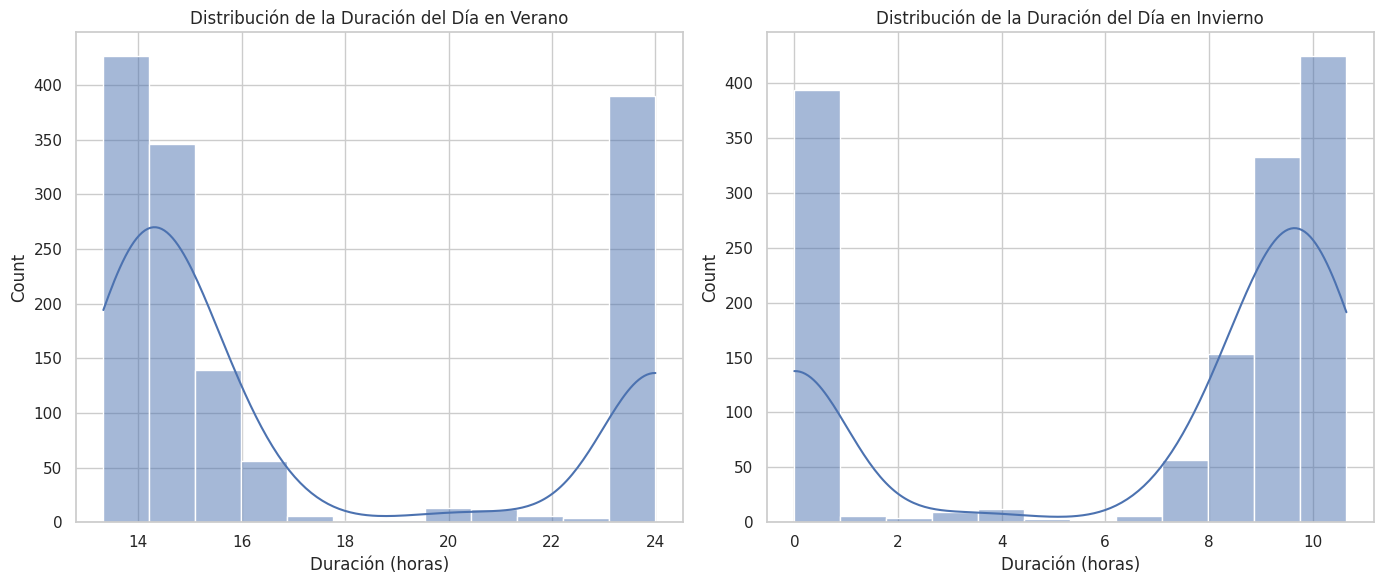

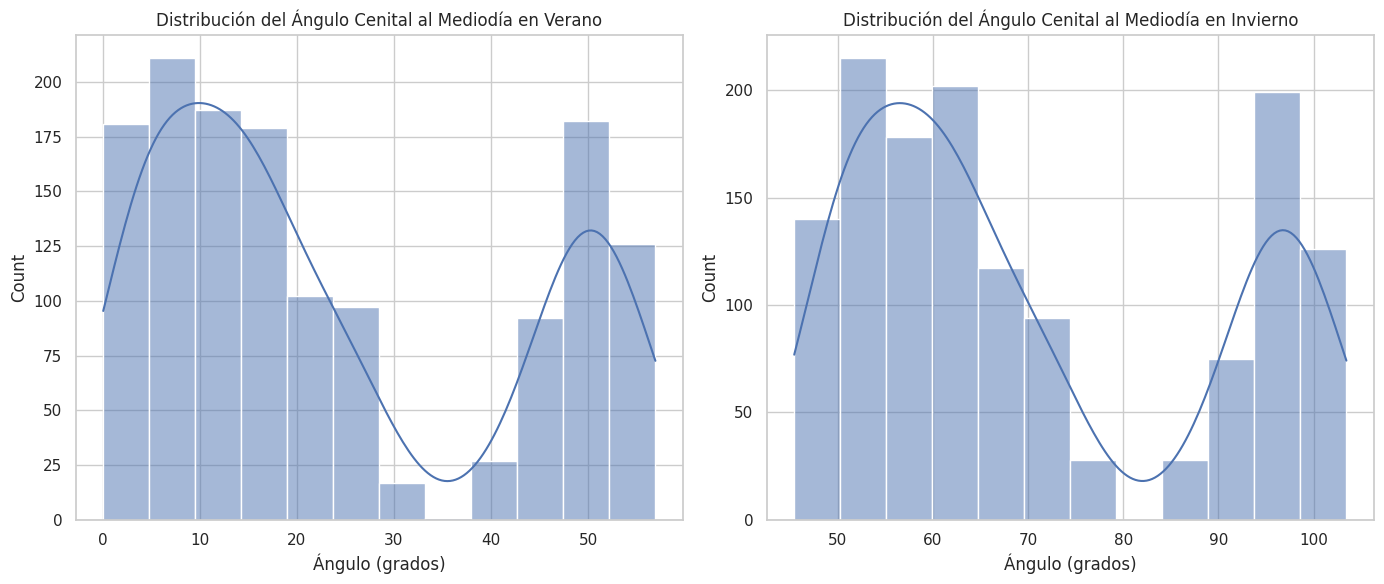

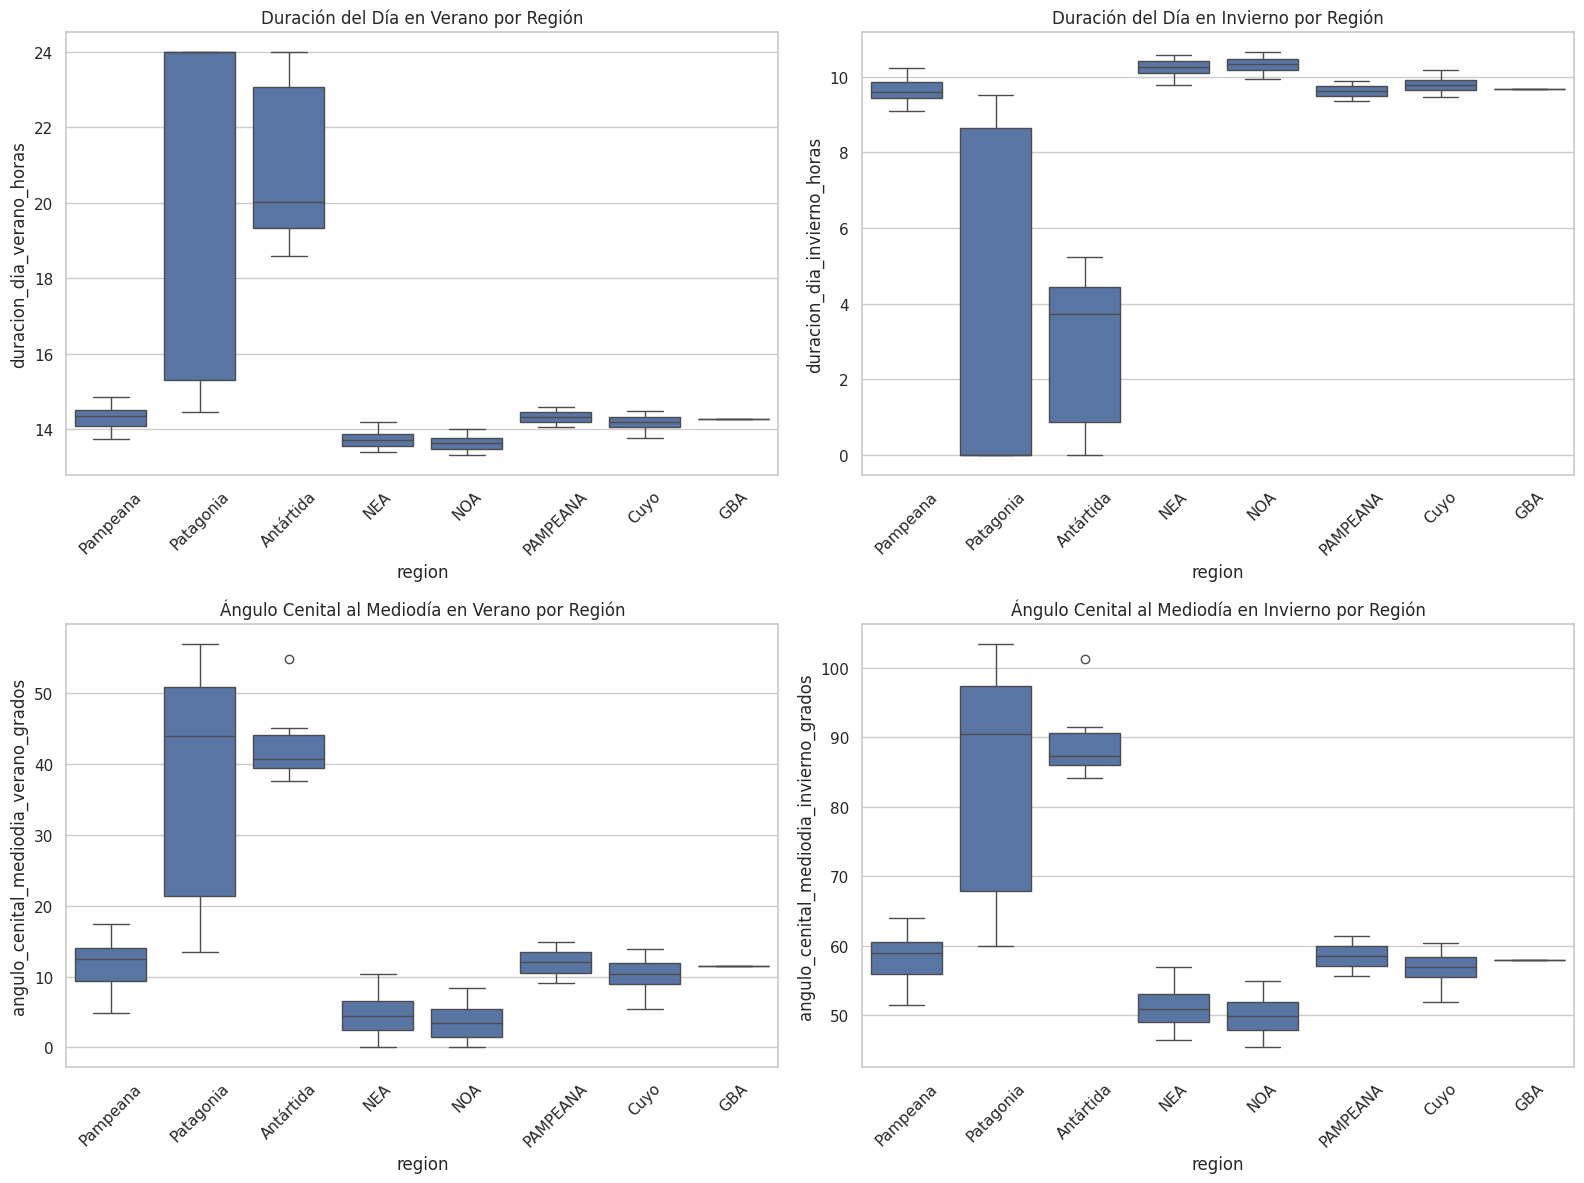

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv('datos/dataset_cleaned_tabular_engineered.csv')

# Configuración general de los gráficos
sns.set_theme(style="whitegrid")

# 1. Distribución de la Duración del Día en Verano e Invierno
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['duracion_dia_verano_horas'], kde=True)
plt.title('Distribución de la Duración del Día en Verano')
plt.xlabel('Duración (horas)')

plt.subplot(1, 2, 2)
sns.histplot(df['duracion_dia_invierno_horas'], kde=True)
plt.title('Distribución de la Duración del Día en Invierno')
plt.xlabel('Duración (horas)')

plt.tight_layout()
plt.show()

# 2. Distribución del Ángulo Cenital al Mediodía en Verano e Invierno
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['angulo_cenital_mediodia_verano_grados'], kde=True)
plt.title('Distribución del Ángulo Cenital al Mediodía en Verano')
plt.xlabel('Ángulo (grados)')

plt.subplot(1, 2, 2)
sns.histplot(df['angulo_cenital_mediodia_invierno_grados'], kde=True)
plt.title('Distribución del Ángulo Cenital al Mediodía en Invierno')
plt.xlabel('Ángulo (grados)')

plt.tight_layout()
plt.show()

# 4. Boxplots comparando las variables astronómicas por región
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.boxplot(ax=axes[0, 0], x='region', y='duracion_dia_verano_horas', data=df)
axes[0, 0].set_title('Duración del Día en Verano por Región')
axes[0, 0].tick_params(axis='x', rotation=45)

sns.boxplot(ax=axes[0, 1], x='region', y='duracion_dia_invierno_horas', data=df)
axes[0, 1].set_title('Duración del Día en Invierno por Región')
axes[0, 1].tick_params(axis='x', rotation=45)

sns.boxplot(ax=axes[1, 0], x='region', y='angulo_cenital_mediodia_verano_grados', data=df)
axes[1, 0].set_title('Ángulo Cenital al Mediodía en Verano por Región')
axes[1, 0].tick_params(axis='x', rotation=45)

sns.boxplot(ax=axes[1, 1], x='region', y='angulo_cenital_mediodia_invierno_grados', data=df)
axes[1, 1].set_title('Ángulo Cenital al Mediodía en Invierno por Región')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Aqui es importante destacar observando los histogramas y diagramas de cajas la gran diversidad de datos que disponemos analizando el territoria Argentino. Esto debido a su gran extension geografica. Lo cual nos aporta un gran valor pudiendo conformar una dataset cuya representacion de la poblacion es representativa en terminos estadisticos. 

### Proceso de incorporacion de una variable target mas precisa y valiosa - 4.1
El proyecto Prediction Of Worldwide Energy Resources (POWER) de la NASA es la solución idónea para este desafío. Ofrece un conjunto de datos de acceso libre y gratuito, con parámetros solares y meteorológicos derivados de observaciones satelitales (como los del proyecto CERES) y modelos de asimilación.8 De manera crucial, POWER proporciona los parámetros exactos necesarios para este análisis: GHI, DNI y DHI, disponibles en series temporales horarias y diarias con una cobertura global que abarca varias décadas.


In [ ]:
import pandas as pd
import numpy as np
import requests
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

dataset_file = 'datos/dataset_cleaned_tabular_engineered.csv'

try:
    df_stations = pd.read_csv(dataset_file)
except FileNotFoundError:
    print(f"El archivo '{dataset_file}' no fue encontrado.")
    exit()

variables = {
    'ALLSKY_SFC_SW_DWN': 'ghi',
    'ALLSKY_SFC_SW_DIFF': 'dhi',
    'ALLSKY_SFC_SW_DNI': 'dni'
}

''' Esta esta es similar a la etapa de augmentacion del dataset introducida anteriormente. Ahora se consumen las variables:
        - ALLSKY_SFC_SW_DWN: irradiancia horizontal global (GHI, por sus siglas en inglés)
        - ALLSKY_SFC_SW_DIFF: irradiancia horizontal difusa (DHI, por sus siglas en inglés)
        - ALLSKY_SFC_SW_DNI: irradiancia normal directa (DNI, por sus siglas en inglés)
    El target inicialmente se definira como GHI pero, es posible que un futuro se contemple alguna combinacion mas valiosa entre estas variables. Por ejemplo DNI/GHI.
'''

# Función para procesar una estación y una variable
def fetch_monthly_average(station_row, nasa_variable, target_variable):
    lat = station_row['latitud']
    lon = station_row['longitud']
    station_name = station_row['estacion']

    api_url = (
        f"https://power.larc.nasa.gov/api/temporal/monthly/point"
        f"?parameters={nasa_variable}&community=SB&longitude={lon}"
        f"&latitude={lat}&start=1991&end=2020&format=JSON"
    )

    try:
        response = requests.get(api_url, timeout=30)
        response.raise_for_status()
        data = response.json()
        data_raw = data.get('properties', {}).get('parameter', {}).get(nasa_variable, {})
        if not data_raw:
            return station_name, [np.nan]*12  # Ningún dato disponible

        df = pd.DataFrame.from_dict(data_raw, orient='index', columns=[f'{target_variable}_mensual'])
        df.replace(-999, np.nan, inplace=True)
        df.reset_index(inplace=True)
        df.rename(columns={'index': 'fecha_str'}, inplace=True)
        df['fecha'] = pd.to_datetime(df['fecha_str'], format='%Y%m', errors='coerce')
        df.dropna(subset=['fecha'], inplace=True)
        df['mes'] = df['fecha'].dt.month
        monthly_avg = df.groupby('mes')[f'{target_variable}_mensual'].mean().to_dict()
        monthly_values = [monthly_avg.get(i, np.nan) for i in range(1, 13)]
        return station_name, monthly_values

    except requests.exceptions.RequestException as e:
        print(f"\nError en la solicitud para {station_name}, variable {target_variable}: {e}")
    except (KeyError, TypeError, AttributeError) as e:
        print(f"\nError procesando JSON para {station_name}, variable {target_variable}: {e}")

    return station_name, [np.nan]*12  # Fallback en caso de error

# Número de threads a usar (ajustar según ancho de banda y CPU)
max_workers = 6

for nasa_variable, target_variable in variables.items():
    print(f"\nProcesando variable {target_variable} en paralelo...")
    df_monthly_avg = pd.DataFrame(columns=['estacion'] + [f'{target_variable}_mensual_promedio_{i:02d}' for i in range(1, 13)])

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {
            executor.submit(fetch_monthly_average, row, nasa_variable, target_variable): idx
            for idx, row in df_stations.iterrows()
        }

        for future in tqdm(as_completed(futures), total=len(futures), desc=f"Obteniendo {target_variable}"):
            station_name, monthly_values = future.result()
            new_row = pd.Series([station_name] + monthly_values, index=df_monthly_avg.columns)
            df_monthly_avg = pd.concat([df_monthly_avg, new_row.to_frame().T], ignore_index=True)

    # Calcular promedio anual
    df_monthly_avg[target_variable] = df_monthly_avg[[f'{target_variable}_mensual_promedio_{i:02d}' for i in range(1, 13)]].mean(axis=1)
    df_final = df_monthly_avg[['estacion', target_variable]].copy()
    df_stations = pd.merge(df_stations, df_final, on='estacion', how='left')

# Guardar dataset final
df_stations.to_csv('datos/dataset_cleaned_tabular_engineered_with_target.csv', index=False)
print("\n¡Proceso completado y dataset guardado!")



Procesando variable ghi en paralelo...


Obteniendo ghi: 100%|██████████| 1402/1402 [18:58<00:00,  1.23it/s]



Procesando variable dhi en paralelo...


Obteniendo dhi: 100%|██████████| 1402/1402 [18:55<00:00,  1.23it/s]



Procesando variable dni en paralelo...


Obteniendo dni: 100%|██████████| 1402/1402 [16:52<00:00,  1.38it/s]


¡Proceso completado y dataset guardado!


### Visualizacion del mapa de GHI y diagramas de dispercion 4.2

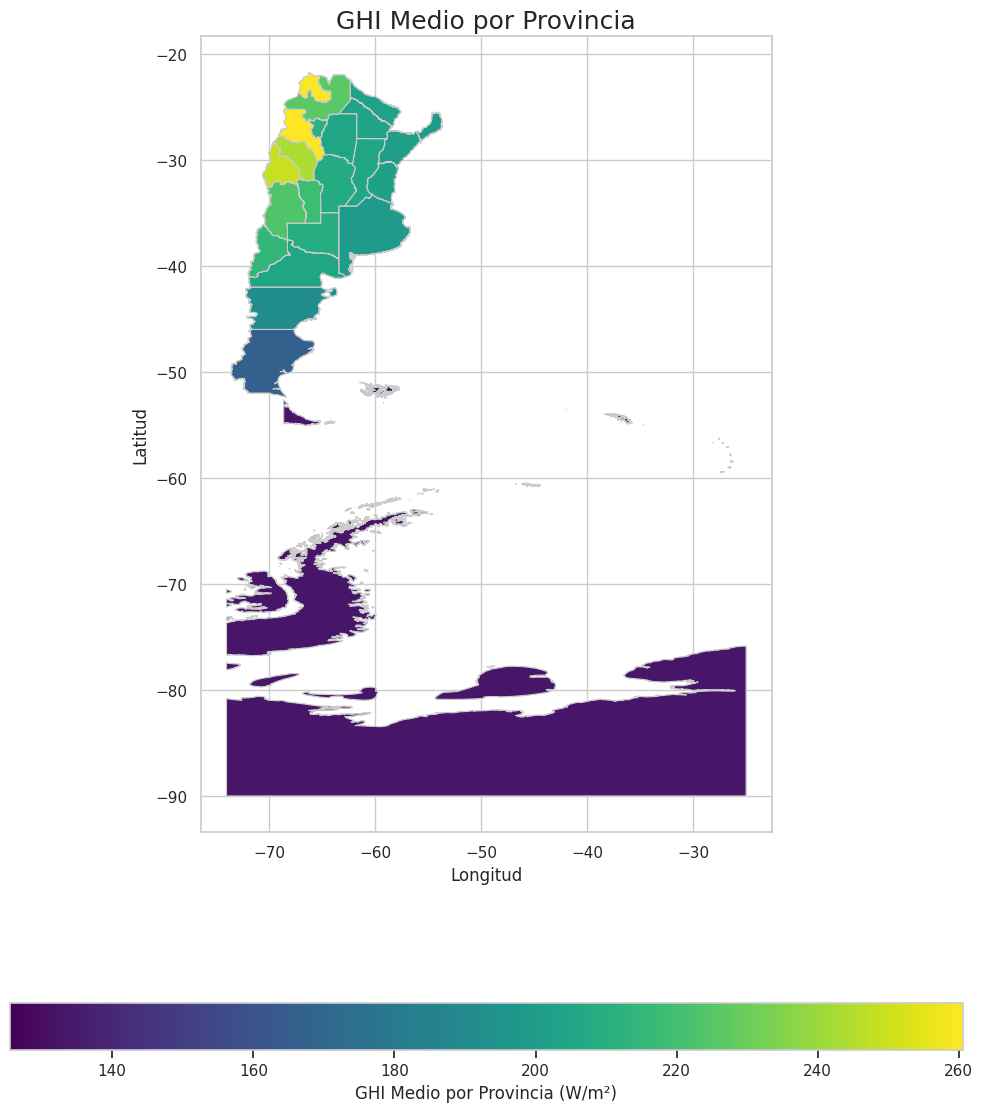

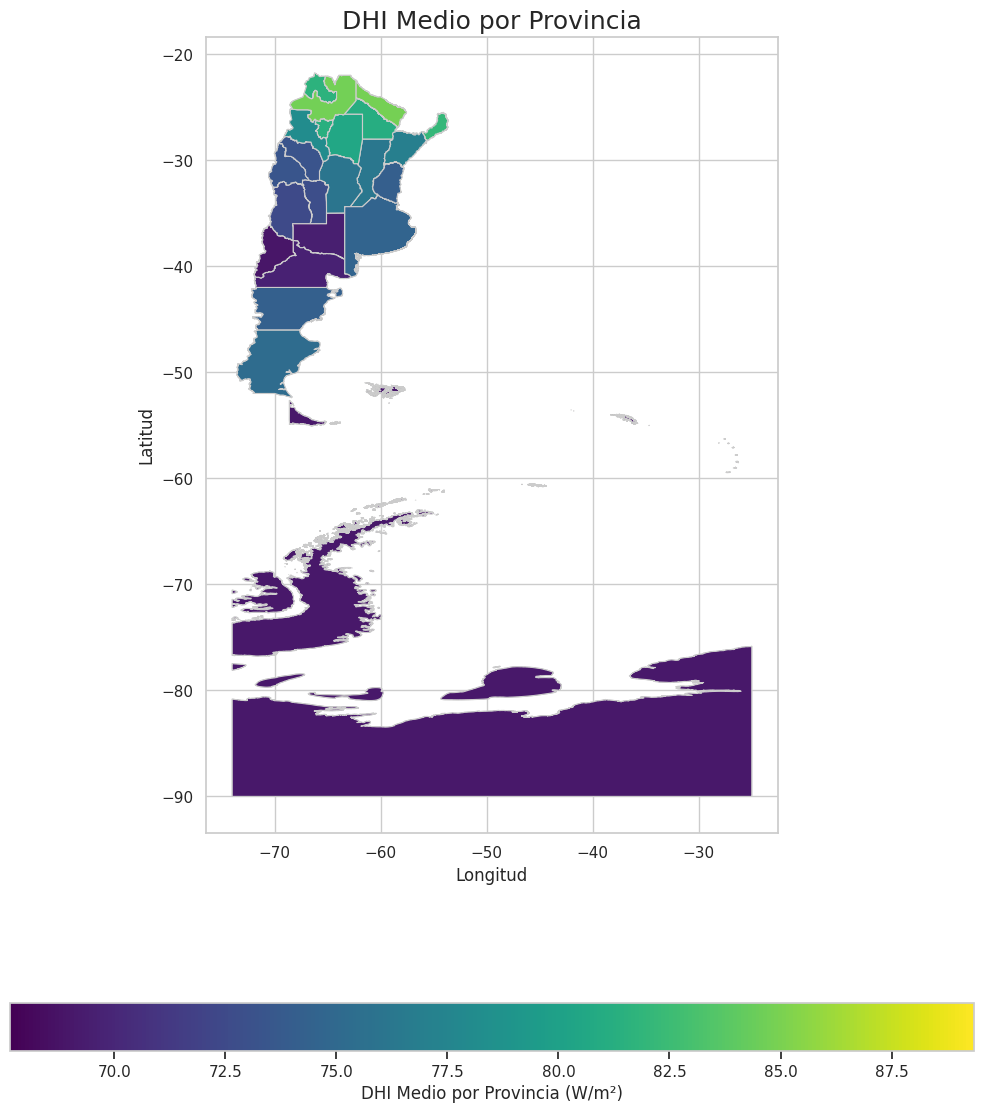

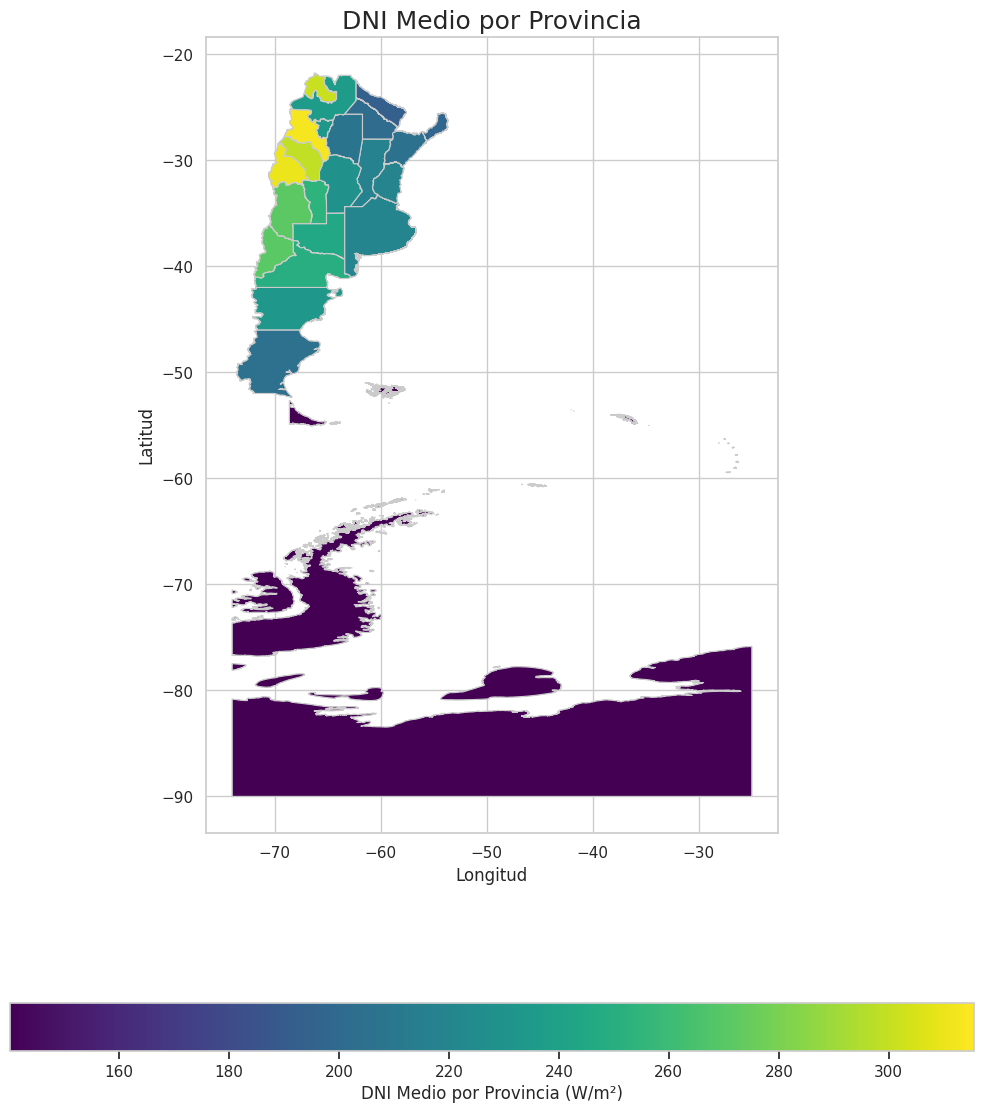

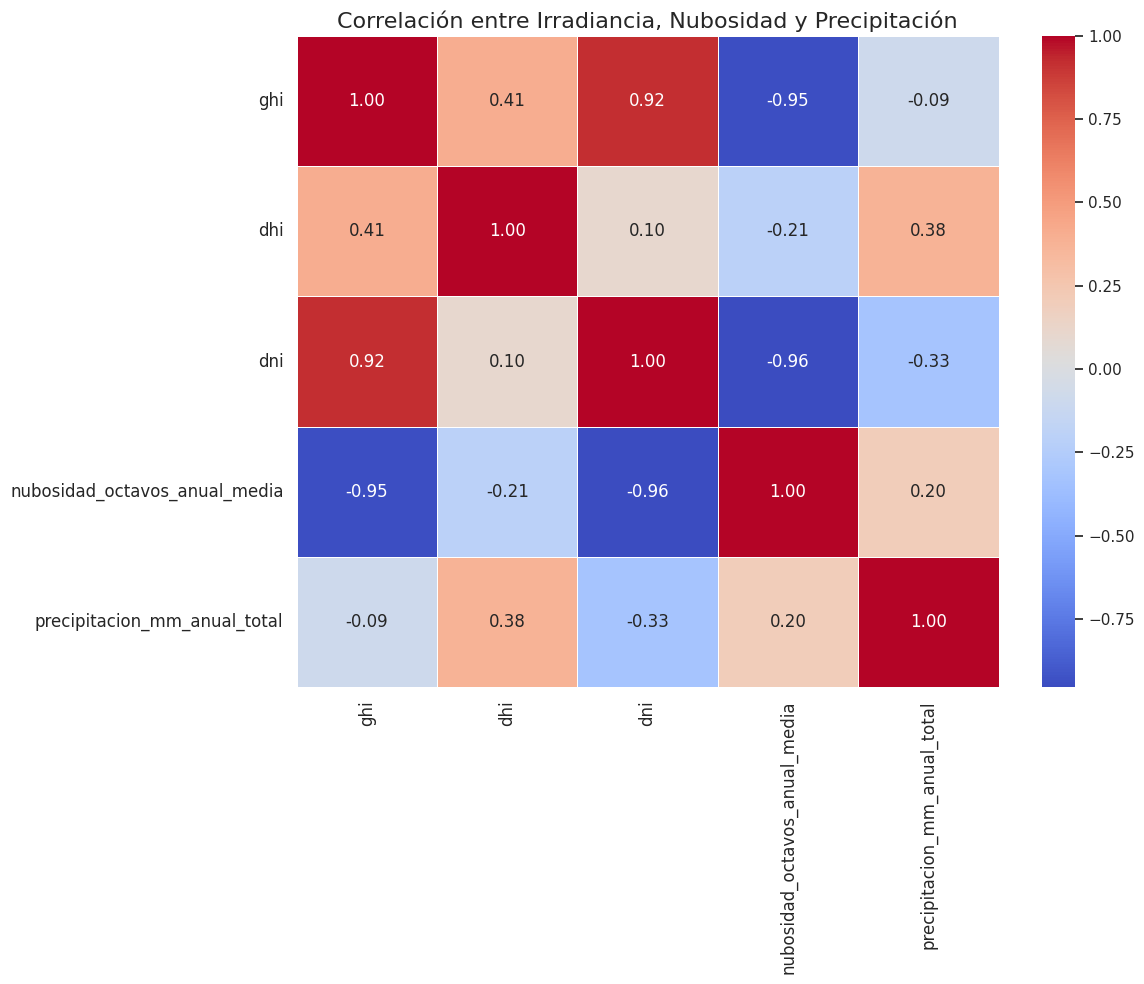

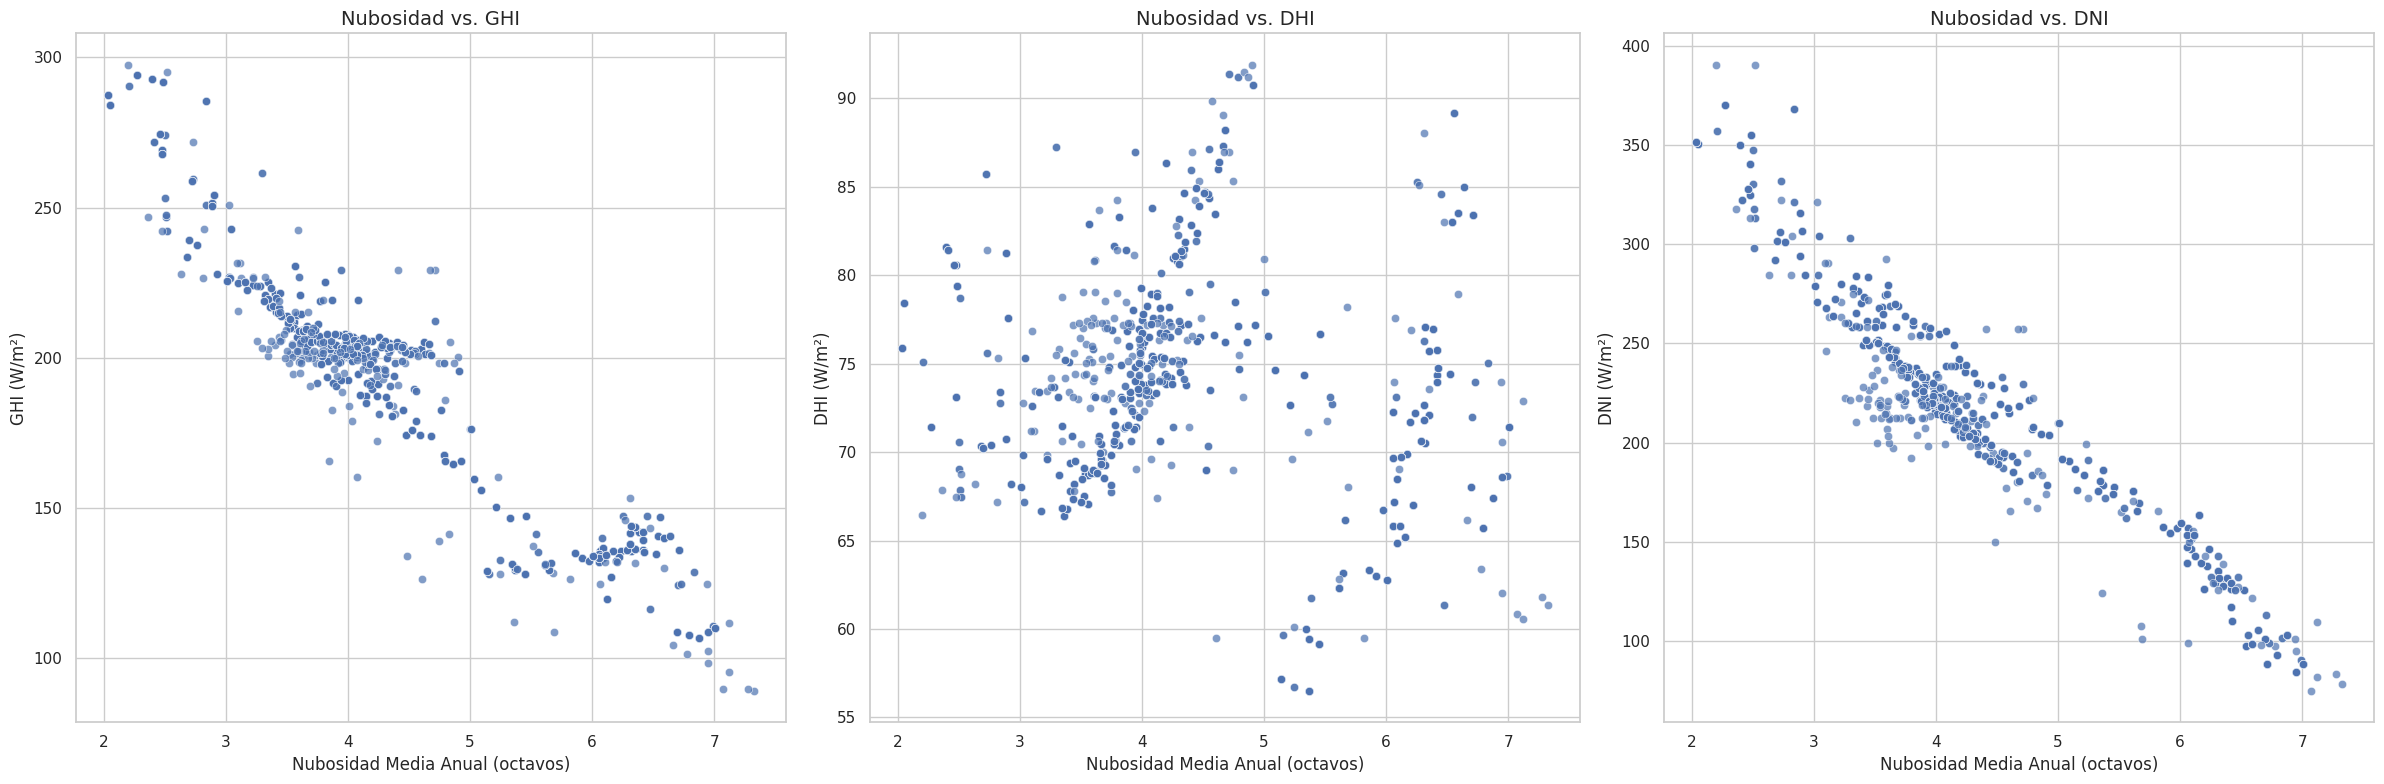

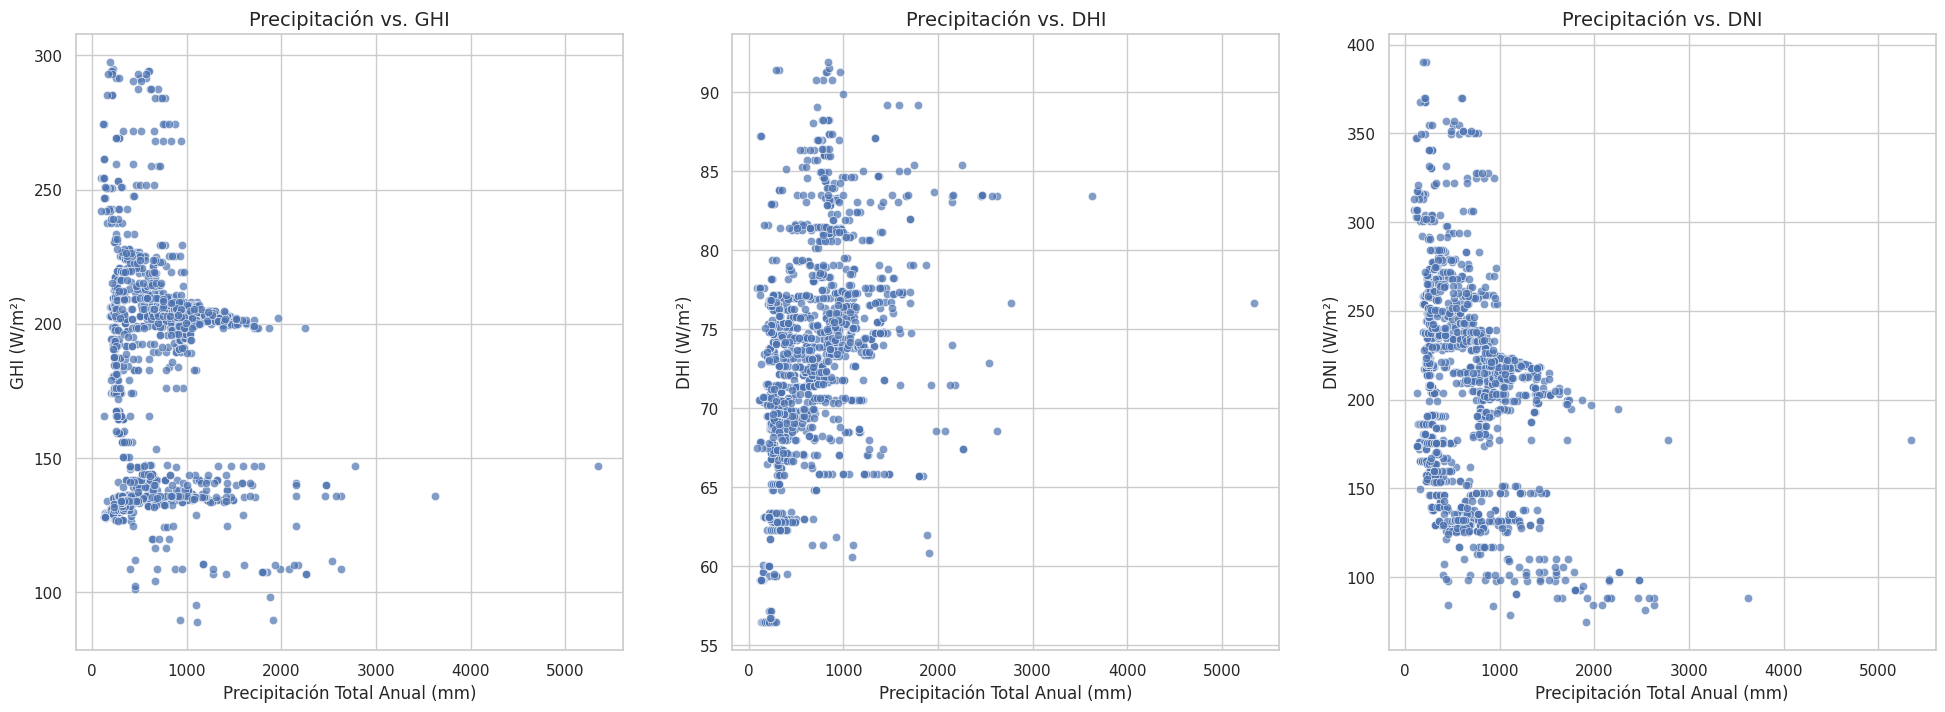

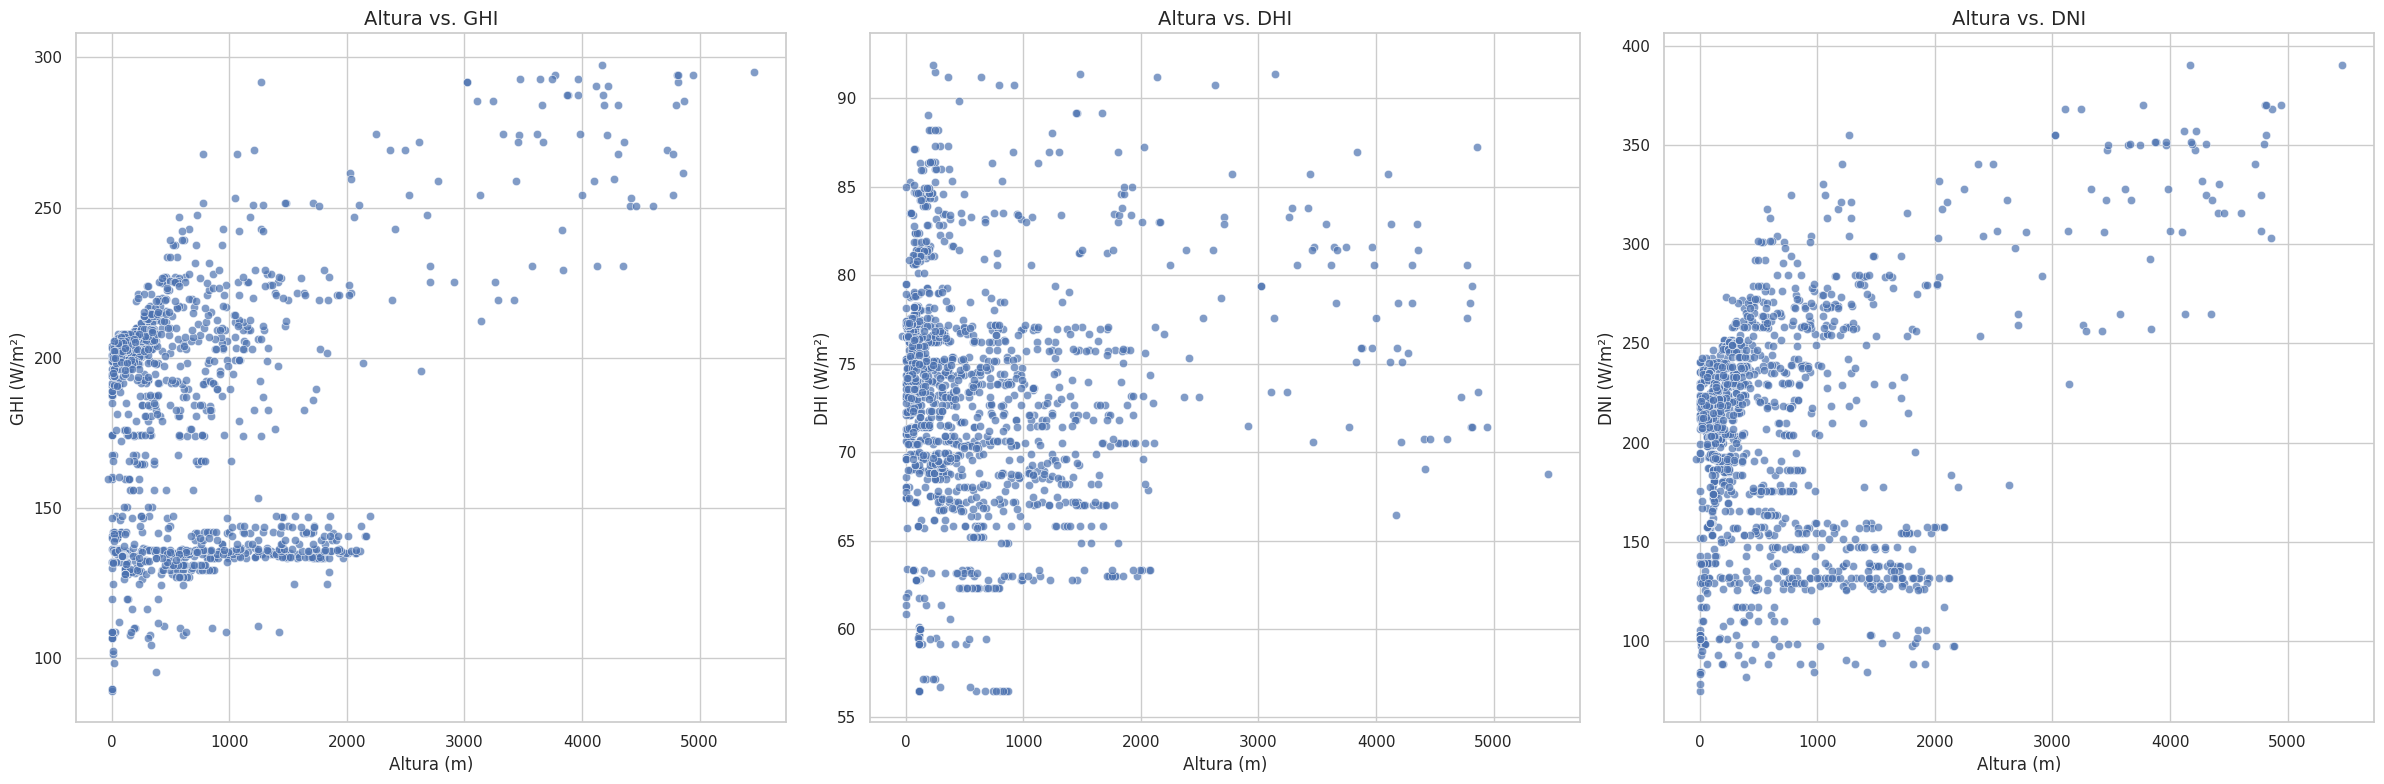

In [3]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import seaborn as sns
from unidecode import unidecode
import re

def limpiar_texto(texto):
    if not isinstance(texto, str):
        return texto
    limpio = unidecode(texto)
    limpio = re.sub(r'[\s-]+', '_', limpio)
    limpio = re.sub(r'[^\w]', '', limpio)
    return limpio.lower()


try:
    df_stations = pd.read_csv('datos/dataset_cleaned_tabular_engineered_with_target.csv')
except FileNotFoundError:
    print("El archivo 'dataset_cleaned_tabular_engineered_with_target.csv' no fue encontrado.")
    exit()

sns.set_theme(style="whitegrid")

#  Mapa de GHI medio por provincia 
def plot_ghi_map(df, target_variable='ghi', cmap='viridis', title='GHI Medio por Provincia'):
    """
    Plots a choropleth map of average GHI by province.

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        target_variable (str): Column name for the target variable (ghi, dhi, dni).
        cmap (str): Colormap for the plot.
        title (str): Title of the plot.
    """
    # Calcular el GHI medio por provincia
    df_ghi_provincia = df.groupby('provincia')[target_variable].mean().reset_index()

    # Renombrar la columna a su nombre final
    df_ghi_provincia.rename(columns={target_variable: 'target_media_provincial'}, inplace=True)

    # Limpiar los nombres de las provincias para la unión
    df_ghi_provincia['provincia_limpia'] = df_ghi_provincia['provincia'].apply(limpiar_texto)

    mapa_correcciones = {
        'tierra_del_fueg': 'tierra_del_fuego_antartida_e_islas_del_atlantico_sur',
        'santiago_del_es': 'santiago_del_estero',
        'capital_federal': 'ciudad_autonoma_de_buenos_aires'
    }
    df_ghi_provincia['provincia_limpia'] = df_ghi_provincia['provincia_limpia'].replace(mapa_correcciones)

    # Preparar los datos del mapa
    ruta_mapa_provincias = "datos/provincia/provinciaPolygon.shp"
    mapa_provincias = geopandas.read_file(ruta_mapa_provincias)

    mapa_provincias['provincia_limpia'] = mapa_provincias['nam'].apply(limpiar_texto)

    # Unir dataframes 
    mapa_final_ghi = pd.merge(
        mapa_provincias,
        df_ghi_provincia,
        on='provincia_limpia',
        how='left'
    )

    #  Dibujar mapa final 
    fig, ax = plt.subplots(1, 1, figsize=(10, 12))

    mapa_final_ghi.plot(
        column='target_media_provincial',
        ax=ax,
        legend=True,
        cmap=cmap,
        linewidth=0.8,
        edgecolor='0.8',
        missing_kwds={
            "color": "lightgrey",
            "edgecolor": "red",
            "hatch": "///",
            "label": "Sin datos",
        },
        legend_kwds={'label': f"{title} (W/m²)", 'orientation': "horizontal"}
    )

    ax.set_title(title, fontsize=18)
    ax.set_xlabel('Longitud')
    ax.set_ylabel('Latitud')
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.savefig(f'graficos/{title.replace(" ", "_")}.png', dpi=300)
    plt.show()

plot_ghi_map(df_stations, target_variable='ghi', cmap='viridis', title='GHI Medio por Provincia')
plot_ghi_map(df_stations, target_variable='dhi', cmap='viridis', title='DHI Medio por Provincia')
plot_ghi_map(df_stations, target_variable='dni', cmap='viridis', title='DNI Medio por Provincia')

#  Correlación entre Irradiancia, Nubosidad y Precipitación - Sospecha de alta corralacion, que se confirma con esta matriz de correlacion
plt.figure(figsize=(12, 10))
correlation_matrix = df_stations[[
    'ghi', 'dhi', 'dni', 'nubosidad_octavos_anual_media', 'precipitacion_mm_anual_total'
]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, fmt=".2f")
plt.title('Correlación entre Irradiancia, Nubosidad y Precipitación', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('graficos/correlacion_irradiancia_clima.png', dpi=300)  # Exportar
plt.show()

#  Diagramas de Dispersión: Nubosidad vs. Irradiancia 
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

sns.scatterplot(ax=axes[0], x='nubosidad_octavos_anual_media', y='ghi', data=df_stations, alpha=0.7)
axes[0].set_title('Nubosidad vs. GHI', fontsize=14)
axes[0].set_xlabel('Nubosidad Media Anual (octavos)', fontsize=12)
axes[0].set_ylabel('GHI (W/m²)', fontsize=12)

sns.scatterplot(ax=axes[1], x='nubosidad_octavos_anual_media', y='dhi', data=df_stations, alpha=0.7)
axes[1].set_title('Nubosidad vs. DHI', fontsize=14)
axes[1].set_xlabel('Nubosidad Media Anual (octavos)', fontsize=12)
axes[1].set_ylabel('DHI (W/m²)', fontsize=12)

sns.scatterplot(ax=axes[2], x='nubosidad_octavos_anual_media', y='dni', data=df_stations, alpha=0.7)
axes[2].set_title('Nubosidad vs. DNI', fontsize=14)
axes[2].set_xlabel('Nubosidad Media Anual (octavos)', fontsize=12)
axes[2].set_ylabel('DNI (W/m²)', fontsize=12)

plt.tight_layout()
plt.savefig('graficos/nubosidad_vs_irradiancia.png', dpi=300) 
plt.show()

#  Diagramas de Dispersión: Precipitación vs. Irradiancia 
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

sns.scatterplot(ax=axes[0], x='precipitacion_mm_anual_total', y='ghi', data=df_stations, alpha=0.7)
axes[0].set_title('Precipitación vs. GHI', fontsize=14)
axes[0].set_xlabel('Precipitación Total Anual (mm)', fontsize=12)
axes[0].set_ylabel('GHI (W/m²)', fontsize=12)

sns.scatterplot(ax=axes[1], x='precipitacion_mm_anual_total', y='dhi', data=df_stations, alpha=0.7)
axes[1].set_title('Precipitación vs. DHI', fontsize=14)
axes[1].set_xlabel('Precipitación Total Anual (mm)', fontsize=12)
axes[1].set_ylabel('DHI (W/m²)', fontsize=12)

sns.scatterplot(ax=axes[2], x='precipitacion_mm_anual_total', y='dni', data=df_stations, alpha=0.7)
axes[2].set_title('Precipitación vs. DNI', fontsize=14)
axes[2].set_xlabel('Precipitación Total Anual (mm)', fontsize=12)
axes[2].set_ylabel('DNI (W/m²)', fontsize=12)

#  Diagramas de Dispersión: Altura vs. Irradiancia 
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

sns.scatterplot(ax=axes[0], x='altura', y='ghi', data=df_stations, alpha=0.7)
axes[0].set_title('Altura vs. GHI', fontsize=14)
axes[0].set_xlabel('Altura (m)', fontsize=12)
axes[0].set_ylabel('GHI (W/m²)', fontsize=12)

sns.scatterplot(ax=axes[1], x='altura', y='dhi', data=df_stations, alpha=0.7)
axes[1].set_title('Altura vs. DHI', fontsize=14)
axes[1].set_xlabel('Altura (m)', fontsize=12)
axes[1].set_ylabel('DHI (W/m²)', fontsize=12)

sns.scatterplot(ax=axes[2], x='altura', y='dni', data=df_stations, alpha=0.7)
axes[2].set_title('Altura vs. DNI', fontsize=14)
axes[2].set_xlabel('Altura (m)', fontsize=12)
axes[2].set_ylabel('DNI (W/m²)', fontsize=12)

plt.tight_layout()
plt.savefig('graficos/precipitacion_vs_irradiancia.png', dpi=300) 
plt.show()

/tmp/ipykernel_841352/2139172858.py:23: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  argentina_polygon = pais_completo.unary_union


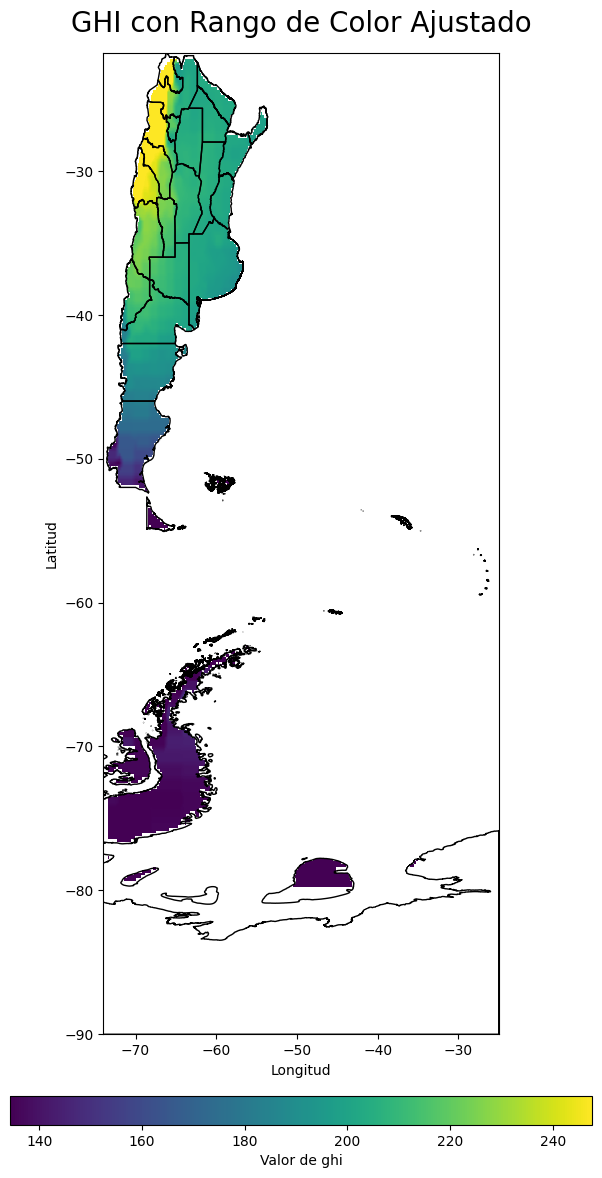

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from scipy.interpolate import LinearNDInterpolator

## Funciones para generar un mapa de calor de la variable GHI a lo largo del territorio Argentino

def generar_mapa_final_sjoin(df, variable_a_mapear, cmap=None, titulo=None, grid_resolution=300, vmin=None, vmax=None):
    # Obtengo las coordenadas limpias
    df_valid = df.dropna(subset=['longitud', 'latitud', variable_a_mapear])
    if df_valid.empty:
        print("No hay datos válidos para graficar.")
        return

    points = df_valid[['longitud', 'latitud']].values
    values = df_valid[variable_a_mapear].values

    # Traigo el mapa 
    ruta_mapa_provincias = "datos/provincia/provinciaPolygon.shp"
    try:
        mapa_provincias = gpd.read_file(ruta_mapa_provincias)
        pais_completo = mapa_provincias.dissolve()
        argentina_polygon = pais_completo.unary_union
    except Exception as e:
        print(f"Error cargando el mapa: {e}")
        return

    # Se genera una malla intepolada para poder cubrir suavemente todo el territorio
    min_lon, min_lat, max_lon, max_lat = argentina_polygon.bounds
    x_coords = np.linspace(min_lon, max_lon, grid_resolution)
    y_coords = np.linspace(min_lat, max_lat, grid_resolution)
    grid_x, grid_y = np.meshgrid(x_coords, y_coords)

    interpolator = LinearNDInterpolator(points, values)
    grid_z = interpolator(grid_x, grid_y)

    # Mascara via sjoin 
    gdf_grid = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy(grid_x.ravel(), grid_y.ravel()),
        crs=mapa_provincias.crs
    )
    gdf_arg = gpd.GeoDataFrame(geometry=[argentina_polygon], crs=mapa_provincias.crs)

    # Solo conservar puntos dentro de Argentina
    inside_points = gpd.sjoin(gdf_grid, gdf_arg, how="inner")
    mask = np.zeros(gdf_grid.shape[0], dtype=bool)
    mask[inside_points.index] = True
    mask = mask.reshape(grid_x.shape)

    grid_z[~mask] = np.nan

    # Plot
    fig, ax = plt.subplots(figsize=(10, 13))
    ax.set_aspect('equal')
    if titulo is None:
        titulo = f'Mapa de Calor de "{variable_a_mapear.replace("_", " ").title()}"'

    im = ax.imshow(grid_z, extent=(min_lon, max_lon, min_lat, max_lat),
                   origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
    mapa_provincias.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.0)

    ax.set_title(titulo, fontsize=20, pad=15)
    ax.set_xlabel('Longitud')
    ax.set_ylabel('Latitud')

    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.05, shrink=0.6)
    cbar.set_label(f'Valor de {variable_a_mapear}')
    plt.tight_layout()
    plt.show()


df_stations = pd.read_csv('datos/dataset_cleaned_tabular_engineered_with_target.csv')
vmin_ajustado = df_stations['ghi'].quantile(0.15)
vmax_ajustado = df_stations['ghi'].quantile(0.95)

generar_mapa_final_sjoin(
    df=df_stations,
    variable_a_mapear='ghi',
    vmin=vmin_ajustado,
    vmax=vmax_ajustado,
    titulo='GHI con Rango de Color Ajustado',
    grid_resolution=350  # Mas resolución
)


--- 1. Diagnóstico de la Tabla de Datos ---
Tipos de datos de las columnas clave:
longitud    float64
latitud     float64
ghi         float64
dtype: object

Estadísticas de las columnas clave:
          longitud      latitud          ghi
count  1402.000000  1402.000000  1402.000000
mean    -64.652192   -47.103794   182.875815
std       5.877828    18.566932    40.605006
min     -73.500000   -80.000000    89.070806
25%     -68.500000   -69.500000   136.570139
50%     -66.000000   -40.000000   198.793222
75%     -62.000000   -31.500000   206.280271
max     -34.616700   -22.000000   297.582000

--- 2. Generando Mapa de Puntos (sin interpolación) ---


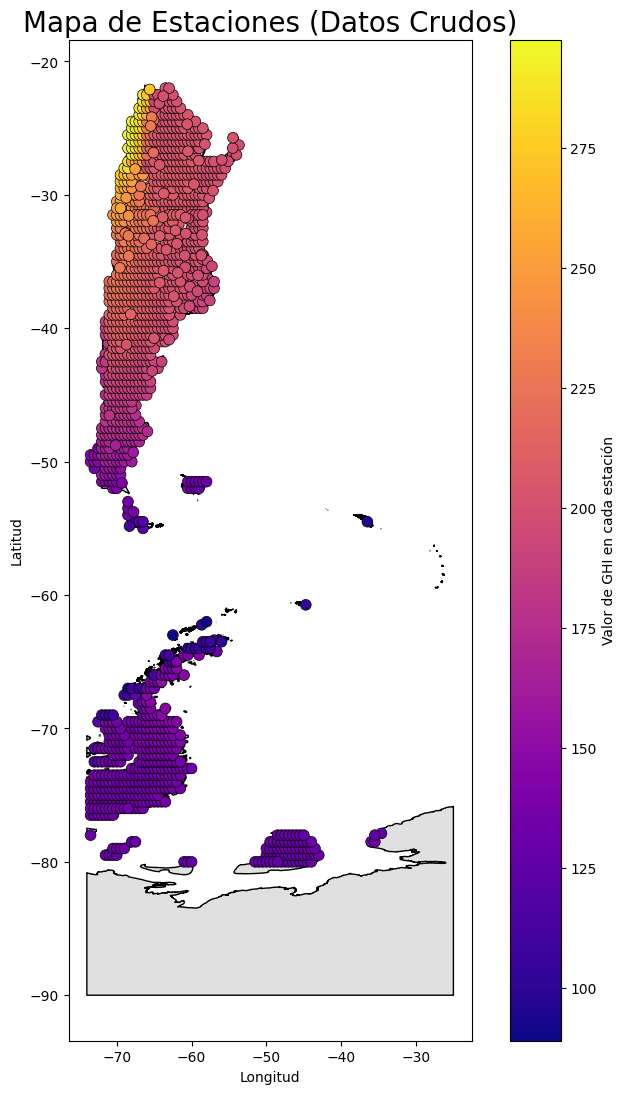

In [ ]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt

try:
   
    print("--- 1. Diagnóstico de la Tabla de Datos ---")
    print("Tipos de datos de las columnas clave:")
    print(df_stations[['longitud', 'latitud', 'ghi']].dtypes)
    print("\nEstadísticas de las columnas clave:")
    print(df_stations[['longitud', 'latitud', 'ghi']].describe())

    # Tambien mostrar datos crudos sin radar
    print("\n--- 2. Generando Mapa de Puntos (sin interpolación) ---")
    ruta_mapa_provincias = "datos/provincia/provinciaPolygon.shp"
    pais_completo = geopandas.read_file(ruta_mapa_provincias).dissolve()

    fig, ax = plt.subplots(1, 1, figsize=(10, 13))
    
    # Dibujar el contorno del país como fondo
    pais_completo.plot(ax=ax, facecolor='#E0E0E0', edgecolor='black')

    # Dibujar un punto por cada estación. El color de cada punto es su valor de GHI.
    scatter = ax.scatter(
        df_stations['longitud'],
        df_stations['latitud'],
        c=df_stations['ghi'],
        cmap='plasma',
        s=60, # Tamaño de los puntos
        edgecolor='black',
        linewidth=0.5
    )

    ax.set_title('Mapa de Estaciones (Datos Crudos)', fontsize=20)
    ax.set_xlabel('Longitud')
    ax.set_ylabel('Latitud')
    fig.colorbar(scatter, label='Valor de GHI en cada estación')
    plt.show()

except NameError:
    print("\nERROR: No se encontró el DataFrame llamado 'df_stations'. Asegúrate de que esté cargado.")
except KeyError:
    print("\nERROR: No se encontró una de las columnas requeridas ('longitud', 'latitud', 'ghi').")
except Exception as e:
    print(f"\nOcurrió un error inesperado: {e}")

## Selección de Variables Predictoras - *Features*

### Geográficas
- **Latitud** (grados)  
- **Longitud** (grados)  
- **Altura** (metros sobre el nivel del mar)  

### Astronómicas
- **Ángulo cenital en el solsticio de verano al mediodía** (grados)  
- **Ángulo cenital en el solsticio de invierno al mediodía** (grados)  
- **Duración del día en horas el primer día de invierno**  
- **Duración del día en horas el primer día de verano**  

### Meteorológicas
En principio, se hará uso de todas las variables meteorológicas disponibles, así como de aquellas generadas mediante técnicas de *feature engineering*.

> Cabe destacar que este proceso se ha realizado **antes del particionado** del conjunto de datos (*split*), debido a la naturaleza del mismo: se dispone de **N filas independientes**, cada una correspondiente a una estación meteorológica con sus respectivas características. Esto permite generar nuevas variables por fila sin incurrir en riesgo de *data leakage*.



## SPLIT y Reducción de dimensionalidad TODO